###### Financial markets are significantly influenced by public perception, news, and social media activity. With the increasing volume of tweets related to financial markets and specific stocks, we have a unique opportunity to explore the relationship between Twitter sentiment and stock market Pedriction. By quantifying sentiment from Twitter data, we aim to uncover insights that could help predict future stock price trends, providing valuable information for investors and traders.



In [1]:
import pandas as pd
import re
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [2]:
df=pd.read_csv(r"C:\Users\sony\Downloads\Final_project\stock_tweets.csv")

In [3]:
df

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name  
0      Tesla, Inc.  
1      Tesla, Inc.  
2      Tesla, Inc.  
3      Tesla, Inc.  
4      Tesla, Inc.  
...            ...  
80788   XPeng Inc.  
80789   XPeng Inc.  
80790   XPeng Inc.  
80791   XPeng Inc.  
80792   XPeng Inc.  

[80793 rows x 4 columns]

In [4]:
df.isnull().sum()

Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64

## Data cleaning 

In [5]:
# Define the cleaning function
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions 
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags 
    text = re.sub(r'#', '', text)    
        
    # Remove non-ASCII characters (optional; useful only if dealing with special symbols)
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Remove extra whitespace
    text = " ".join(text.split())
    
    return text



In [6]:
# Apply the cleaning function to the 'Tweet' column
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)
print(df[ 'Cleaned_Tweet'])

0        mainstream media has done an amazing job at br...
1        tesla delivery estimates are at around 364k fr...
2        3/ even if i include 63.0m unvested rsus as of...
3        hahaha why are you still trying to stop tesla ...
4        stop trying to kill kids, you sad deranged old...
                               ...                        
80788    some of the fastest growing tech stocks on the...
80789    with earnings on the horizon, here is a quick ...
80790    our record delivery results are a testimony of...
80791    we delivered 10,412 smart evs in sep 2021, rea...
80792    why can xpeng p5 deliver outstanding performan...
Name: Cleaned_Tweet, Length: 80793, dtype: object


In [7]:
df

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name                                      Cleaned_Tweet  
0      Tesla, Inc.  mainstream media has done an amazing job at br...  
1      Tesla, Inc.  tesla delivery estimates are at around 364k fr...  
2      Tesla, Inc.  3/ even if i include 63.0m unvested rsus as of...  
3      Tesla, Inc.  hahaha why are you still trying to stop tesla ...  
4      Tesla, Inc.  stop trying to kill kids, you sad deranged old...  
...            ...                                                ...  
80788   XPeng Inc.  some of the fastest growing tech stocks on the...  
80789   XPeng Inc.  with earnings on the horizon, here is a quick ...  
80790   XPeng Inc.  our record delivery results are a testimony of...  
80791   XPeng Inc.  we delivered 10,412 smart evs in sep 2021, rea...  
80792   XPeng Inc.  why can xpeng p5 deliver outstanding performan...  

[80793 rows x 5 columns]

# Sentiment analysis  

In [8]:
sentiment_data=pd.read_csv(r"C:\Users\sony\Downloads\stock_sentiment_sentiment_score_data.csv")

In [9]:
sentiment_data

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name                                      Cleaned_Tweet  \
0      Tesla, Inc.  mainstream media has done an amazing job at br...   
1      Tesla, Inc.  tesla delivery estimates are at around 364k fr...   
2      Tesla, Inc.  3/ even if i include 63.0m unvested rsus as of...   
3      Tesla, Inc.  hahaha why are you still trying to stop tesla ...   
4      Tesla, Inc.  stop trying to kill kids, you sad deranged old...   
...            ...                                                ...   
80788   XPeng Inc.  some of the fastest growing tech stocks on the...   
80789   XPeng Inc.  with earnings on the horizon, here is a quick ...   
80790   XPeng Inc.  our record delivery results are a testimony of...   
80791   XPeng Inc.  we delivered 10,412 smart evs in sep 2021, rea...   
80792   XPeng Inc.  why can xpeng p5 deliver outstanding performan...   

       Sentiment_Score  Negative   Neutral  Positive  
0            -0.302432  0.464329  0.373774  0.161897  
1             0.091480  0.017830  0.872859  0.109311  
2            -0.043222  0.086374  0.870474  0.043152  
3            -0.946019  0.951288  0.043443  0.005269  
4            -0.972591  0.975343  0.021905  0.002752  
...                ...       ...       ...       ...  
80788         0.935332  0.001599  0.061470  0.936931  
80789         0.501693  0.005826  0.486656  0.507518  
80790         0.838613  0.002815  0.155757  0.841428  
80791         0.940092  0.001330  0.057248  0.941422  
80792         0.598110  0.031071  0.339748  0.629181  

[80793 rows x 9 columns]

In [10]:
data = sentiment_data.drop([ 'Company Name', 'Tweet','Cleaned_Tweet'], axis=1)
data['Date'] = pd.to_datetime(data['Date']).dt.date
data

Date Stock Name  Sentiment_Score  Negative   Neutral  Positive
0      2022-09-29       TSLA        -0.302432  0.464329  0.373774  0.161897
1      2022-09-29       TSLA         0.091480  0.017830  0.872859  0.109311
2      2022-09-29       TSLA        -0.043222  0.086374  0.870474  0.043152
3      2022-09-29       TSLA        -0.946019  0.951288  0.043443  0.005269
4      2022-09-29       TSLA        -0.972591  0.975343  0.021905  0.002752
...           ...        ...              ...       ...       ...       ...
80788  2021-10-07       XPEV         0.935332  0.001599  0.061470  0.936931
80789  2021-10-04       XPEV         0.501693  0.005826  0.486656  0.507518
80790  2021-10-01       XPEV         0.838613  0.002815  0.155757  0.841428
80791  2021-10-01       XPEV         0.940092  0.001330  0.057248  0.941422
80792  2021-09-30       XPEV         0.598110  0.031071  0.339748  0.629181

[80793 rows x 6 columns]

In [11]:
# Calculate the mean sentiment score for each date
new_data = data.groupby(['Date', 'Stock Name'])['Sentiment_Score'].mean().reset_index()
new_data

Date Stock Name  Sentiment_Score
0     2021-09-30       AAPL        -0.156070
1     2021-09-30        AMD         0.556356
2     2021-09-30       AMZN         0.164063
3     2021-09-30        DIS         0.013555
4     2021-09-30       GOOG         0.262706
...          ...        ...              ...
5905  2022-09-29         PG        -0.034116
5906  2022-09-29       PYPL         0.293659
5907  2022-09-29       TSLA         0.057059
5908  2022-09-29        TSM         0.136276
5909  2022-09-29         ZS         0.732291

[5910 rows x 3 columns]

# Merge Data 

In [12]:
data2=pd.read_csv(r"C:\Users\sony\Downloads\Final_project\stock_yfinance_data.csv")
data2

Date        Open        High         Low       Close   Adj Close  \
0     2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1     2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2     2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3     2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4     2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...          ...         ...         ...         ...         ...         ...   
6295  2022-09-23   13.090000   13.892000   12.860000   13.710000   13.710000   
6296  2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   
6297  2022-09-27   14.580000   14.800000   13.580000   13.710000   13.710000   
6298  2022-09-28   13.050000   13.421000   12.690000   13.330000   13.330000   
6299  2022-09-29   12.550000   12.850000   11.850000   12.110000   12.110000   

        Volume Stock Name  
0     53868000       TSLA  
1     51094200       TSLA  
2     91449900       TSLA  
3     55297800       TSLA  
4     43898400       TSLA  
...        ...        ...  
6295  28279600       XPEV  
6296  27891300       XPEV  
6297  21160800       XPEV  
6298  31799400       XPEV  
6299  33044800       XPEV  

[6300 rows x 8 columns]

In [13]:
new_data['Date'] = pd.to_datetime(new_data['Date'])
data2['Date'] = pd.to_datetime(data2['Date'])

# Merge the two datasets on 'Date' and 'Stock Name'
merged_data = pd.merge(data2, new_data, on=['Date', 'Stock Name'], how='inner')

# Display the merged dataset
print(merged_data)

           Date        Open        High         Low       Close   Adj Close  \
0    2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1    2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2    2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3    2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4    2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...         ...         ...         ...         ...         ...         ...   
4179 2022-08-30   18.280001   18.600000   17.950001   18.260000   18.260000   
4180 2022-09-07   15.750000   16.530001   15.630000   16.000000   16.000000   
4181 2022-09-12   16.549999   16.639999   15.980000   16.360001   16.360001   
4182 2022-09-19   14.300000   15.725000   14.290000   15.640000   15.640000   
4183 2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   

        Volume Stock Name  Sentiment_Score  
0     

In [14]:
merged_data

Date        Open        High         Low       Close   Adj Close  \
0    2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1    2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2    2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3    2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4    2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...         ...         ...         ...         ...         ...         ...   
4179 2022-08-30   18.280001   18.600000   17.950001   18.260000   18.260000   
4180 2022-09-07   15.750000   16.530001   15.630000   16.000000   16.000000   
4181 2022-09-12   16.549999   16.639999   15.980000   16.360001   16.360001   
4182 2022-09-19   14.300000   15.725000   14.290000   15.640000   15.640000   
4183 2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   

        Volume Stock Name  Sentiment_Score  
0     53868000       TSLA         0.073668  
1     51094200       TSLA         0.179260  
2     91449900       TSLA         0.070886  
3     55297800       TSLA         0.080504  
4     43898400       TSLA         0.187303  
...        ...        ...              ...  
4179  14484300       XPEV        -0.296016  
4180  14641500       XPEV         0.011943  
4181  21170100       XPEV         0.523038  
4182  18193100       XPEV         0.805236  
4183  27891300       XPEV         0.250781  

[4184 rows x 9 columns]

In [15]:
merged_data.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Stock Name         0
Sentiment_Score    0
dtype: int64

In [16]:
merged_data['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [17]:
merged_data[merged_data['Date'] == '2022-09-26']


Date        Open        High         Low       Close   Adj Close  \
248  2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
500  2022-09-26  237.050003  241.449997  236.899994  237.449997  236.782700   
752  2022-09-26  135.580002  136.820007  134.990005  135.710007  134.753662   
1223 2022-09-26  113.300003  117.339996  113.129997  115.150002  115.150002   
1462 2022-09-26   98.610001  100.440002   98.379997   98.809998   98.809998   
1710 2022-09-26   67.870003   68.739998   66.250000   66.300003   66.300003   
1962 2022-09-26  149.660004  153.770004  149.639999  150.770004  150.520309   
2191 2022-09-26  225.600006  232.699997  223.009995  224.070007  224.070007   
2442 2022-09-26   73.470001   74.190002   72.919998   73.010002   73.010002   
2757 2022-09-26  465.869995  484.109985  465.209991  480.299988  479.434509   
2940 2022-09-26   98.949997  100.660004   98.059998   98.120003   98.120003   
3007 2022-09-26   39.230000   39.380001   38.630001   38.930000   38.284790   
3123 2022-09-26  147.000000  151.190002  145.350006  146.320007  146.320007   
3254 2022-09-26   27.559999   27.700001   26.860001   26.969999   26.610596   
3410 2022-09-26  129.770004  132.449997  126.879997  127.339996  127.339996   
3735 2022-09-26  277.859985  288.950012  273.670013  274.920013  274.920013   
3985 2022-09-26   17.770000   18.400000   17.530001   17.620001   17.620001   
4183 2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   

        Volume Stock Name  Sentiment_Score  
248   58076900       TSLA         0.142712  
500   27694200       MSFT        -0.021828  
752    7396400         PG        -0.021828  
1223  62723300       AMZN        -0.021828  
1462  22437900       GOOG         0.145559  
1710  82898700        AMD         0.336841  
1962  93339400       AAPL         0.317340  
2191   8234300       NFLX         0.178992  
2442  13441500        TSM         0.274694  
2757   4001900       COST         0.043017  
2940   9760500        DIS        -0.044135  
3007  21345700         VZ         0.008958  
3123   7862400        CRM        -0.176520  
3254  44786400       INTC        -0.191966  
3410   7095100         BA         0.147347  
3735   3358900       ENPH         0.865417  
3985  42024500        NIO         0.372849  
4183  27891300       XPEV         0.250781

In [18]:
stocks_count=merged_data['Stock Name'].value_counts()
stocks_count

Stock Name
TSLA    252
PG      252
AMZN    252
AAPL    252
TSM     252
NIO     252
MSFT    252
AMD     249
GOOG    238
NFLX    228
META    219
PYPL    186
DIS     184
COST    157
BA      153
INTC    133
KO      133
CRM     116
ZS      102
XPEV     93
ENPH     87
VZ       65
BX       29
NOC      24
F        24
Name: count, dtype: int64

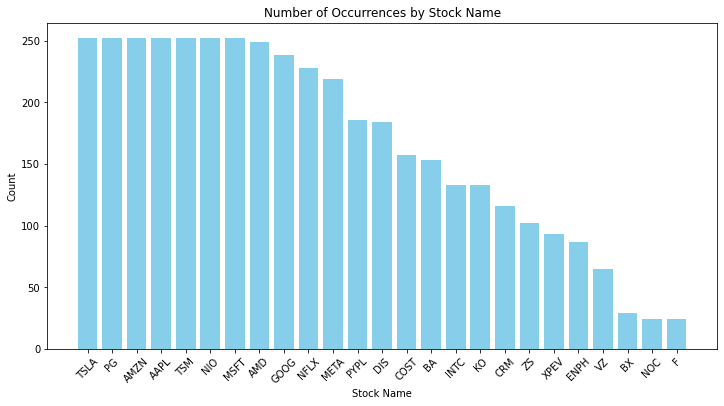

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(stocks_count.index, stocks_count.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Number of Occurrences by Stock Name')
plt.xlabel('Stock Name')
plt.ylabel('Count')
plt.show()

In [20]:
merged_data.describe()

Date         Open         High          Low  \
count                           4184  4184.000000  4184.000000  4184.000000   
mean   2022-03-29 05:25:55.640535296   180.767954   183.712568   177.614537   
min              2021-09-30 00:00:00    11.100000    11.360000    10.930000   
25%              2021-12-29 00:00:00   102.117498   103.920002   100.027500   
50%              2022-03-28 00:00:00   150.165878   152.295006   148.220001   
75%              2022-06-29 00:00:00   233.897499   239.610836   227.807503   
max              2022-09-29 00:00:00   692.349976   700.989990   686.090027   
std                              NaN   127.237590   128.990809   125.238161   

             Close    Adj Close        Volume  Sentiment_Score  
count  4184.000000  4184.000000  4.184000e+03      4184.000000  
mean    180.631801   179.970903  3.481762e+07         0.201198  
min      11.130000    10.906092  5.832000e+05        -0.976610  
25%     101.852501   101.654781  8.373700e+06         0.030689  
50%     150.154999   149.529999  2.135445e+07         0.179340  
75%     234.386669   234.386669  5.392778e+07         0.363015  
max     691.690002   691.690002  2.726620e+08         0.990263  
std     127.086738   126.892707  3.463913e+07         0.291530

In [21]:
# Define the function to plot the close price for any stock
def plot_close_price(stock_data, stock_name):
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    
    # Filter the data for the specific stock
    filtered_data = stock_data[stock_data['Stock Name'] == stock_name]
    
    # Convert 'Date' and 'Close' columns to numpy arrays
    dates = filtered_data['Date'].values
    close_prices = filtered_data['Close'].values
    
    # Create the plot
    plt.figure(figsize=(16,8))
    plt.title(f"{stock_name} Close Price History", fontsize=16)
    plt.plot(dates, close_prices, label="Close Price", color='blue')
    
    # Format the x-axis to show dates nicely
    plt.xlabel('Date', fontsize=14)
    plt.ylabel("Close Price (USD)", fontsize=14)
    plt.xticks(rotation=45)
    
    # Adding grid for better readability
    plt.grid(True)
    
    # Format x-axis to display major ticks by month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Add a legend
    plt.legend([f"{stock_name} Close Price"])
    
    # Display the plot
    plt.show()

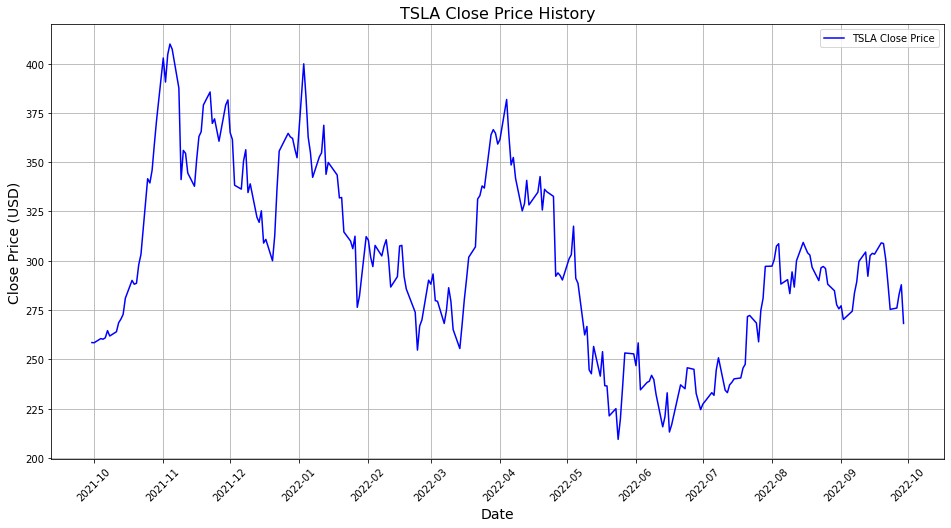

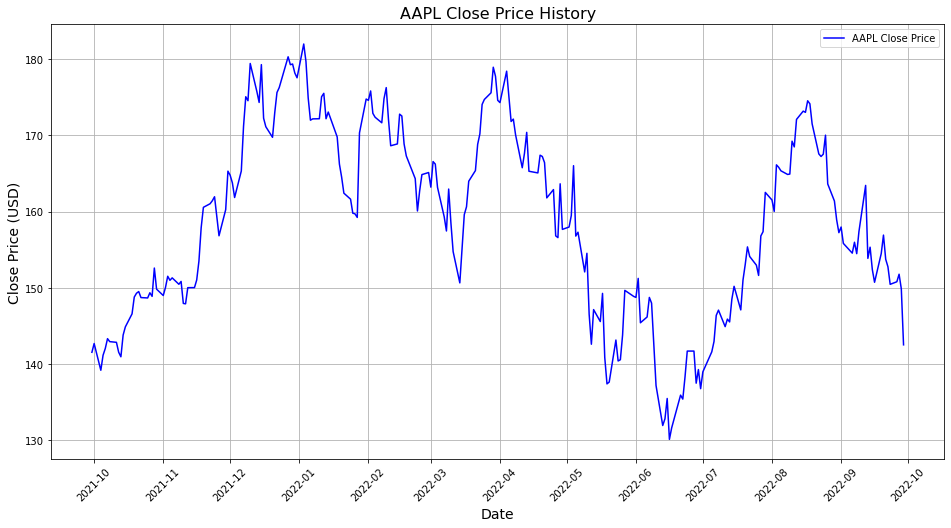

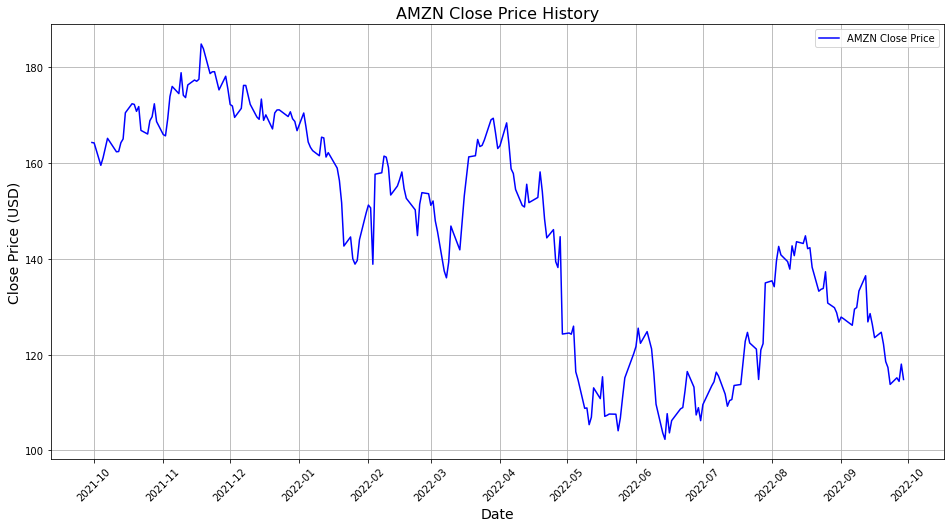

In [22]:
plot_close_price(merged_data, "TSLA")
plot_close_price(merged_data, "AAPL")
plot_close_price(merged_data, "AMZN")


# Relationship between the stock prices and sentiment score

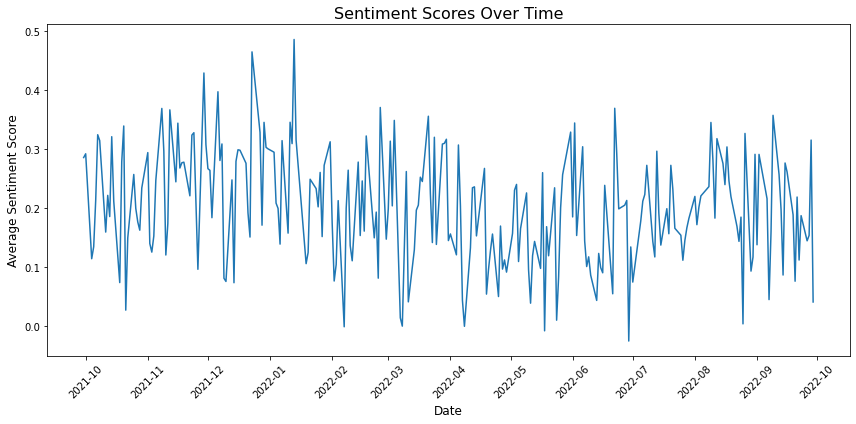

In [23]:

# Ensure the Date column is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

plt.figure(figsize=(12, 6))

# Plot the sentiment score over time without the confidence interval
sns.lineplot(x='Date', y='Sentiment_Score', data=merged_data, ci=None)

# Add labels and title
plt.title('Sentiment Scores Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Improve the x-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()




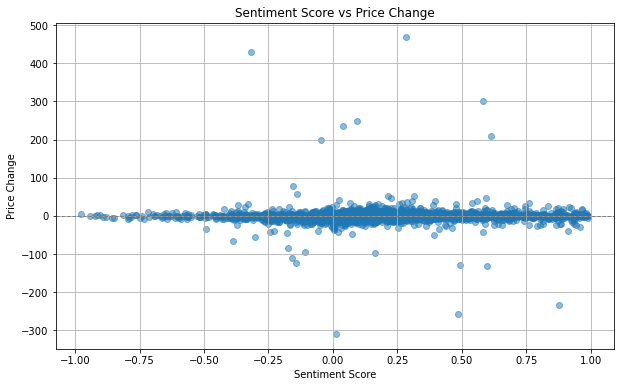

In [24]:
# Calculate price changes
merged_data['Price_Change'] = merged_data['Close'].diff()

# Example scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of sentiment score vs price change
plt.scatter(merged_data['Sentiment_Score'], merged_data['Price_Change'], alpha=0.5)
plt.title('Sentiment Score vs Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change')
plt.axhline(0, color='grey', lw=1, linestyle='--') 
plt.grid()
plt.show()


###### The plot doesn't show a strong linear relationship that changes in stock price are weakly influenced by sentiment scores

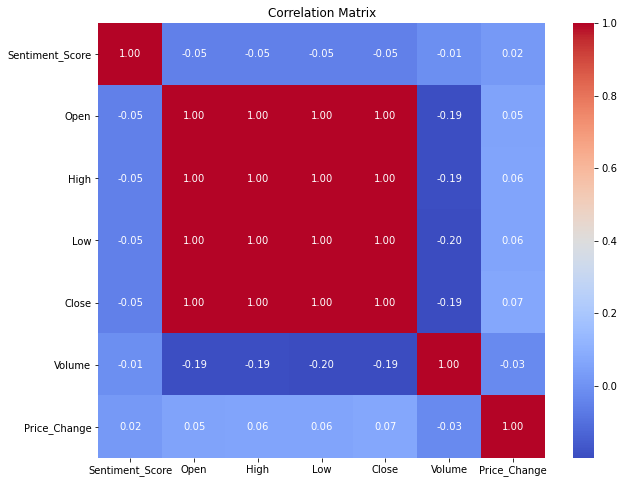

In [25]:
import seaborn as sns

# Select relevant columns for correlation
correlation_data = merged_data[['Sentiment_Score', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


###### The matrix shows weak correlations between the Sentiment_Score and stock price indicators

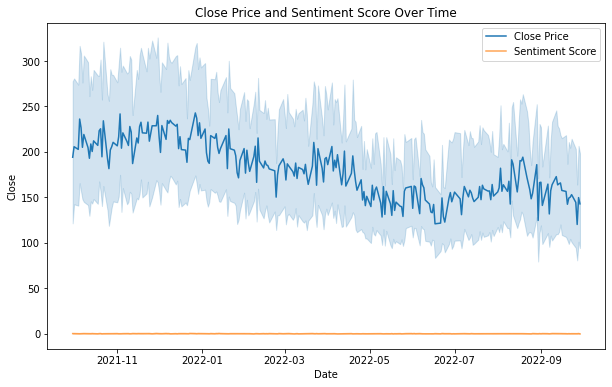

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Date', y='Close', label='Close Price')
sns.lineplot(data=merged_data, x='Date', y='Sentiment_Score', label='Sentiment Score', alpha=0.7)
plt.title('Close Price and Sentiment Score Over Time')
plt.legend()
plt.show()

######  the sentiment does not drastically influence price trends.

In [27]:
# Lag features: Shift sentiment score by 1 day, 3 days, and 7 days
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment_Score'].shift(1)
merged_data['Sentiment_Lag_3'] = merged_data['Sentiment_Score'].shift(3)
merged_data['Sentiment_Lag_7'] = merged_data['Sentiment_Score'].shift(7)

# Lag features: Shift sentiment score by 1 day, 3 days, and 7 days
merged_data['Close_Lag_1'] = merged_data['Close'].shift(1)
merged_data['Close_Lag_3'] = merged_data['Close'].shift(3)
merged_data['Close_Lag_7'] = merged_data['Close'].shift(7)


In [28]:
# Moving Averages of Sentiment Scores
merged_data['Sentiment_Score_MA3'] = merged_data['Sentiment_Score'].rolling(window=3).mean()
merged_data['Sentiment_Score_MA7'] = merged_data['Sentiment_Score'].rolling(window=7).mean()
merged_data['Sentiment_Score_MA14'] = merged_data['Sentiment_Score'].rolling(window=14).mean()
# Moving Averages of Close Prices
merged_data['Close_MA3'] = merged_data['Close'].rolling(window=3).mean()
merged_data['Close_MA7'] = merged_data['Close'].rolling(window=7).mean()
merged_data['Close_MA14'] = merged_data['Close'].rolling(window=14).mean()


In [29]:
# Create volatility features
merged_data['Price_Volatility'] = merged_data['High'] - merged_data['Low']
merged_data['Sentiment_Volatility'] = merged_data['Sentiment_Score'].rolling(window=7).std()

In [30]:
merged_data = merged_data.dropna()
merged_data.head()

Date        Open        High         Low       Close   Adj Close  \
13 2021-10-19  292.510010  292.649994  287.503326  288.089996  288.089996   
14 2021-10-20  288.450012  289.829987  285.793335  288.600006  288.600006   
15 2021-10-21  285.333344  300.000000  285.166656  298.000000  298.000000   
16 2021-10-22  298.500000  303.333344  296.986664  303.226654  303.226654   
17 2021-10-25  316.843323  348.339996  314.733337  341.619995  341.619995   

       Volume Stock Name  Sentiment_Score  Price_Change  ...  Close_Lag_3  \
13   52143300       TSLA         0.131974     -1.946686  ...   272.773346   
14   42096300       TSLA         0.177759      0.510010  ...   281.010010   
15   94444500       TSLA         0.206996      9.399994  ...   290.036682   
16   68642400       TSLA         0.317717      5.226654  ...   288.089996   
17  188556300       TSLA         0.308109     38.393341  ...   288.600006   

    Close_Lag_7  Sentiment_Score_MA3  Sentiment_Score_MA7  \
13   261.829987             0.174433             0.161122   
14   263.980011             0.178690             0.166535   
15   268.573334             0.172243             0.174065   
16   270.359985             0.234157             0.199850   
17   272.773346             0.277607             0.219125   

    Sentiment_Score_MA14   Close_MA3   Close_MA7  Close_MA14  \
13              0.149025  286.378896  276.403338  268.550956   
14              0.156460  288.908895  279.920480  270.701431   
15              0.158441  291.563334  284.124289  273.529526   
16              0.176072  296.608887  288.819528  276.580715   
17              0.192329  314.282216  298.654763  282.396667   

    Price_Volatility  Sentiment_Volatility  
13          5.146667              0.032488  
14          4.036652              0.031498  
15         14.833344              0.034261  
16          6.346680              0.060093  
17         33.606659              0.070799  

[5 rows x 24 columns]

In [31]:
# Drop non-numeric columns like 'Date' and 'Stock Name'
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = merged_data[numeric_columns].corr()

# Correlation of features with Close price
correlation_with_close = correlation_matrix['Close'].sort_values(ascending=False)
print("Correlation Matrix:")
print(correlation_with_close)



Correlation Matrix:
Close                   1.000000
Adj Close               0.999963
Low                     0.999630
High                    0.999576
Open                    0.999152
Close_MA3               0.995013
Close_Lag_1             0.990943
Close_MA7               0.983214
Close_Lag_3             0.973525
Close_MA14              0.960214
Close_Lag_7             0.935863
Price_Volatility        0.666740
Price_Change            0.068146
Sentiment_Volatility    0.025068
Sentiment_Lag_1        -0.048745
Sentiment_Score        -0.049218
Sentiment_Lag_3        -0.049244
Sentiment_Lag_7        -0.058035
Sentiment_Score_MA3    -0.076026
Sentiment_Score_MA7    -0.104726
Sentiment_Score_MA14   -0.127583
Volume                 -0.195892
Name: Close, dtype: float64


###### There doesn't seem to be a strong relationship between the stock's Close price and sentiment scores their lags

In [32]:
# Calculate Spearman correlation for all numeric columns
spearman_corr_matrix = merged_data[numeric_columns].corr(method='spearman')

# Print the Spearman correlation matrix
print("Spearman Correlation Matrix:")
# Correlation of features with Close price
correlation_with_close = spearman_corr_matrix['Close'].sort_values(ascending=False)

print(correlation_with_close)

Spearman Correlation Matrix:
Close                   1.000000
Adj Close               0.999865
Low                     0.999554
High                    0.999491
Open                    0.998976
Close_MA3               0.995256
Close_Lag_1             0.990119
Close_MA7               0.983567
Close_Lag_3             0.971466
Close_MA14              0.963143
Close_Lag_7             0.933033
Price_Volatility        0.780832
Price_Change            0.041315
Sentiment_Volatility   -0.051440
Sentiment_Score        -0.095983
Sentiment_Lag_3        -0.096761
Sentiment_Lag_1        -0.097142
Sentiment_Lag_7        -0.107013
Sentiment_Score_MA3    -0.140578
Sentiment_Score_MA7    -0.178911
Sentiment_Score_MA14   -0.208157
Volume                 -0.259388
Name: Close, dtype: float64


## Predective model

In [33]:
merged_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name', 'Sentiment_Score', 'Price_Change', 'Sentiment_Lag_1',
       'Sentiment_Lag_3', 'Sentiment_Lag_7', 'Close_Lag_1', 'Close_Lag_3',
       'Close_Lag_7', 'Sentiment_Score_MA3', 'Sentiment_Score_MA7',
       'Sentiment_Score_MA14', 'Close_MA3', 'Close_MA7', 'Close_MA14',
       'Price_Volatility', 'Sentiment_Volatility'],
      dtype='object')

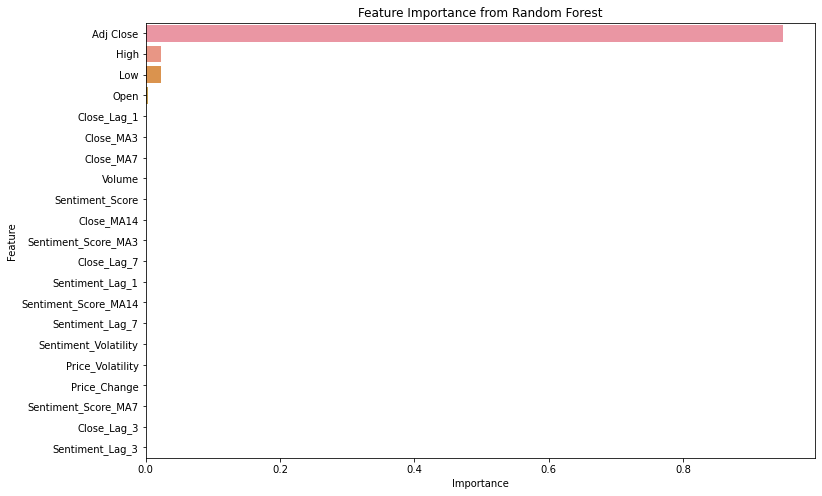

Selected Features by RFE: Index(['Open', 'High', 'Low', 'Adj Close', 'Close_MA3'], dtype='object')


In [172]:

# Drop 'Date' and 'Stock Name' 
merged_data = merged_data.drop(['Date', 'Stock Name'], axis=1)

# Feature Importance using Random Forest
X = merged_data.drop('Close', axis=1)
y = merged_data['Close']  

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance from Random Forest")
plt.show()

# 3. Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)


## Random Forest

In [156]:
def predict_stock_price(merged_data, stock_name, n_past=10, n_future=2):
    data_copy = merged_data.copy()
    
    # Check if 'Date' column exists
    if 'Date' not in data_copy.columns:
        print("The 'Date' column is missing from merged_data.")
        return  
    
    # Convert 'Date' column to datetime format
    data_copy['Date'] = pd.to_datetime(data_copy['Date'])
    
    # Filter data for the specified stock
    stock_data = merged_data[merged_data['Stock Name'] == stock_name]

    # Define the feature columns for the two models
    feature_columns = {
        "with_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Sentiment_Score','Close_MA3','Close_MA7','Price_Volatility'],
        "without_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close','Close_MA3','Close_MA7','Price_Volatility']
    }

    # Create two separate DataFrames: one with sentiment features and one without
    dataframes = {
        "with_sentiment": stock_data[feature_columns["with_sentiment"]].astype(float),
        "without_sentiment": stock_data[feature_columns["without_sentiment"]].astype(float)
    }

    # Standardize the data
    scalers = {
        "with_sentiment": StandardScaler(),
        "without_sentiment": StandardScaler()
    }
    scaled_data = {key: scalers[key].fit_transform(dataframes[key]) for key in dataframes}

    # Define a function to create input sequences (X) and targets (y) for the model
    def create_features_and_target(data, n_past, n_future, target_col_idx):
        X, y = [], []
        for i in range(n_past, len(data) - n_future + 1):
            X.append(data[i - n_past:i, :])  
            y.append(data[i + n_future - 1, target_col_idx])  
        return np.array(X), np.array(y)

    # Create input (X) and output (y) pairs for both datasets
    X_y_data = {key: create_features_and_target(scaled_data[key], n_past, n_future, 3) for key in scaled_data}

    # Reshape the input (X) for Random Forest
    X_y_data = {key: (X.reshape(X.shape[0], -1), y) for key, (X, y) in X_y_data.items()}

    # Split the data into training and testing sets 
    X_train_test_data = {
        key: train_test_split(X, y, test_size=0.2, shuffle=False)
        for key, (X, y) in X_y_data.items()
    }

    # Hyperparameter tuning using Grid Search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Train a Random Forest model for each dataset
    rf_models = {}
    for key, (X_train, X_test, y_train, y_test) in X_train_test_data.items():
        tscv = TimeSeriesSplit(n_splits=5)
        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        rf_models[key] = grid_search.best_estimator_
    
    # Make predictions using the trained models
    predictions = {
        key: model.predict(X_test)
        for key, model in rf_models.items()
        for (X_train, X_test, y_train, y_test) in [X_train_test_data[key]]
    }

    # Define a function to reverse the scaling
    def inverse_transform(scaler, y_pred, y_test, data_shape):
        y_pred_unscaled = np.full((y_pred.shape[0], data_shape[1]), np.nan)
        y_test_unscaled = np.full((y_test.shape[0], data_shape[1]), np.nan)
        
        y_pred_unscaled[:, 3] = y_pred
        y_test_unscaled[:, 3] = y_test
        
        return (scaler.inverse_transform(y_pred_unscaled), scaler.inverse_transform(y_test_unscaled))

    # Reverse the scaling for predictions and actual values
    unscaled_results = {
        key: inverse_transform(scalers[key], predictions[key], y_test, dataframes[key].shape)
        for key, (_, _, _, y_test) in X_train_test_data.items()
    }

    # Define a function to plot the predictions vs actual values
    def plot_predictions(unscaled_data, title):
        plt.figure(figsize=(20, 5))
        plt.plot(unscaled_data[1][:, 3], label='Actual Close Price') 
        plt.plot(unscaled_data[0][:, 3], label='Predicted Close Price')  
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the predictions vs actual values for both models
    plot_predictions(unscaled_results["with_sentiment"], f'Close Price Prediction (With Sentiment) for {stock_name}')
    plot_predictions(unscaled_results["without_sentiment"], f'Close Price Prediction (Without Sentiment) for {stock_name}')
    
    # Evaluate performance for each model
    for key in unscaled_results:
        y_true = unscaled_results[key][1][:, 3]
        y_pred = unscaled_results[key][0][:, 3]
        evaluate_model_performance(y_true, y_pred, stock_name, key)

    # Print future predictions and their dates
    last_date = stock_data['Date'].max()  # Get the last date in the stock data
    future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Generate future business days
    future_predictions = {
        key: unscaled_results[key][0][-n_future:, 3] for key in unscaled_results
    }
    
    # Create DataFrame to display future predictions
    future_results_df = pd.DataFrame({
        'Date': np.tile(future_dates, 2),
        'Model': ['With Sentiment'] * n_future + ['Without Sentiment'] * n_future,
        'Predicted Close Price': np.concatenate(list(future_predictions.values()))
    })

    print(future_results_df)

def evaluate_model_performance(y_true, y_pred, stock_name, model_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Performance of {model_type} model for {stock_name}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.2f}\n")


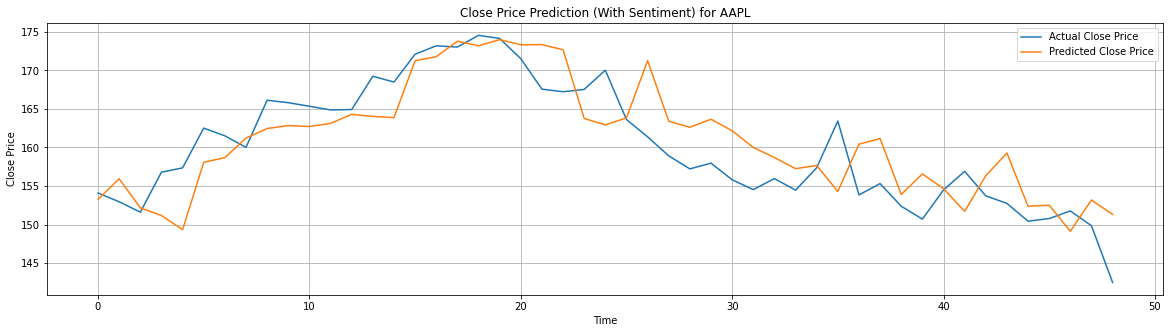

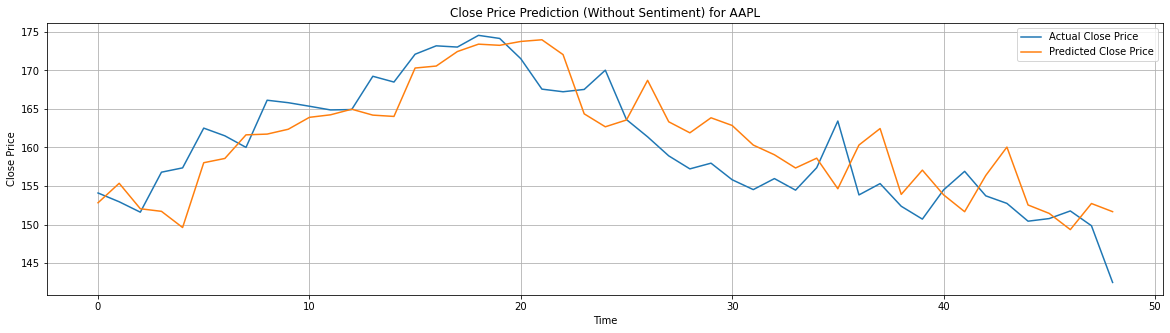

Performance of with_sentiment model for AAPL:
Mean Absolute Error (MAE): 3.71
Mean Squared Error (MSE): 20.29
R-squared (R²): 0.66

Performance of without_sentiment model for AAPL:
Mean Absolute Error (MAE): 3.72
Mean Squared Error (MSE): 20.14
R-squared (R²): 0.66

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment               153.1787
1 2022-10-03     With Sentiment               151.3044
2 2022-09-30  Without Sentiment               152.7231
3 2022-10-03  Without Sentiment               151.6679


In [157]:
predict_stock_price(merged_data, 'AAPL')


## SVM

In [158]:
def predict_stock_price(merged_data, stock_name, n_past=15, n_future=2):
    # Make a copy of the DataFrame to avoid modifying the original
    data_copy = merged_data.copy()
    
    # Check if 'Date' column exists
    if 'Date' not in data_copy.columns:
        print("The 'Date' column is missing from merged_data.")
        return  # Exit the function if 'Date' is not found
    
    # Convert 'Date' column to datetime format
    data_copy['Date'] = pd.to_datetime(data_copy['Date'])
    
    # Filter data for the specified stock
    stock_data = merged_data[merged_data['Stock Name'] == stock_name].copy()


    # Define the feature columns for the two models
    feature_columns = {
        "with_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Sentiment_Score','Close_MA3','Close_MA7','Price_Volatility'],
        "without_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close','Close_MA3','Close_MA7','Price_Volatility']
    }

    # Create two separate DataFrames: one with sentiment features and one without
    dataframes = {
        "with_sentiment": stock_data[feature_columns["with_sentiment"]].astype(float),
        "without_sentiment": stock_data[feature_columns["without_sentiment"]].astype(float)
    }

    # Standardize the data
    scalers = {
        "with_sentiment": StandardScaler(),
        "without_sentiment": StandardScaler()
    }
    scaled_data = {key: scalers[key].fit_transform(dataframes[key]) for key in dataframes}

    # Define a function to create input sequences (X) and targets (y) for the model
    def create_features_and_target(data, n_past, n_future, target_col_idx):
        X, y = [], []
        for i in range(n_past, len(data) - n_future + 1):
            X.append(data[i - n_past:i, :])  # Use the past 'n_past' days of data
            y.append(data[i + n_future - 1, target_col_idx])  # Predict 'n_future' days ahead
        return np.array(X), np.array(y)

    # Create input (X) and output (y) pairs for both datasets
    X_y_data = {key: create_features_and_target(scaled_data[key], n_past, n_future, 3) for key in scaled_data}

    # Reshape the input (X) for SVM
    X_y_data = {key: (X.reshape(X.shape[0], -1), y) for key, (X, y) in X_y_data.items()}

    # Split the data into training and testing sets (no shuffling to maintain time series order)
    X_train_test_data = {
        key: train_test_split(X, y, test_size=0.2, shuffle=False)
        for key, (X, y) in X_y_data.items()
    }

    # Hyperparameter tuning using Grid Search
    param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Only applies to 'rbf' kernel

    }
 
    
    # Train an SVM model for each dataset
    svr_models = {}
    for key, (X_train, X_test, y_train, y_test) in X_train_test_data.items():
        tscv = TimeSeriesSplit(n_splits=5)
        svr = SVR()
        grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        svr_models[key] = grid_search.best_estimator_
        
        # Print cross-validation results
        print(f"Cross-validation scores for {key}: {grid_search.cv_results_['mean_test_score']}")

    # Make predictions using the trained models
    predictions = {
        key: model.predict(X_test)
        for key, model in svr_models.items()
        for (X_train, X_test, y_train, y_test) in [X_train_test_data[key]]
    }

    # Define a function to reverse the scaling
    def inverse_transform(scaler, y_pred, y_test, data_shape):
        y_pred_unscaled = np.full((y_pred.shape[0], data_shape[1]), np.nan)
        y_test_unscaled = np.full((y_test.shape[0], data_shape[1]), np.nan)
        
        y_pred_unscaled[:, 3] = y_pred
        y_test_unscaled[:, 3] = y_test
        
        return (scaler.inverse_transform(y_pred_unscaled), scaler.inverse_transform(y_test_unscaled))

    # Reverse the scaling for predictions and actual values
    unscaled_results = {
        key: inverse_transform(scalers[key], predictions[key], y_test, dataframes[key].shape)
        for key, (_, _, _, y_test) in X_train_test_data.items()
    }

    # Define a function to plot the predictions vs actual values
    def plot_predictions(unscaled_data, title):
        plt.figure(figsize=(20, 5))
        plt.plot(unscaled_data[1][:, 3], label='Actual Close Price', color='blue') 
        plt.plot(unscaled_data[0][:, 3], label='Predicted Close Price', color='orange')  
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the predictions vs actual values for both models
    plot_predictions(unscaled_results["with_sentiment"], f'Close Price Prediction (With Sentiment) for {stock_name}')
    plot_predictions(unscaled_results["without_sentiment"], f'Close Price Prediction (Without Sentiment) for {stock_name}')
    
    # Evaluate performance for each model
    for key in unscaled_results:
        y_true = unscaled_results[key][1][:, 3]
        y_pred = unscaled_results[key][0][:, 3]
        evaluate_model_performance(y_true, y_pred, stock_name, key)

    # Print future predictions and their dates
    last_date = stock_data['Date'].max()  # Get the last date in the stock data
    future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Generate future business days
    future_predictions = {
        key: unscaled_results[key][0][-n_future:, 3] for key in unscaled_results
    }
    
    # Create DataFrame to display future predictions
    future_results_df = pd.DataFrame({
        'Date': np.tile(future_dates, 2),
        'Model': ['With Sentiment'] * n_future + ['Without Sentiment'] * n_future,
        'Predicted Close Price': np.concatenate(list(future_predictions.values()))
    })

    print(future_results_df)

    # Train performance evaluation (overfitting check)
    for key, (X_train, X_test, y_train, y_test) in X_train_test_data.items():
        # Get predictions on training data
        train_predictions = svr_models[key].predict(X_train)
        
        # Reverse scaling for train predictions
        unscaled_train_results = inverse_transform(scalers[key], train_predictions, y_train, dataframes[key].shape)
        
        # Evaluate performance on training data
        y_train_true = unscaled_train_results[1][:, 3]
        y_train_pred = unscaled_train_results[0][:, 3]
        print(f"\nTrain performance of {key} model:")
        evaluate_model_performance(y_train_true, y_train_pred, stock_name, key + ' (Train)')

def evaluate_model_performance(y_true, y_pred, stock_name, model_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Performance of {model_type} model for {stock_name}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    print("-" * 50)


Cross-validation scores for with_sentiment: [-0.66375825 -0.99880901 -0.66375825 -0.94083456 -0.66375825 -0.98489257
 -0.66375825 -1.48408355 -0.66375825 -1.48021304 -0.65311212 -0.99923917
 -0.65311212 -0.93557817 -0.65311212 -0.98381583 -0.65311212 -1.48503124
 -0.65311212 -1.48113475 -0.5196752  -1.01087919 -0.5196752  -0.95255289
 -0.5196752  -0.99743133 -0.5196752  -1.4956678  -0.5196752  -1.49670615
 -0.49195235 -1.03273618 -0.49195235 -0.96715195 -0.49195235 -1.00918303
 -0.49195235 -1.4930588  -0.49195235 -1.49822901 -0.53035504 -1.01882638
 -0.53035504 -0.92149719 -0.53035504 -0.95161671 -0.53035504 -1.35705407
 -0.53035504 -1.37936773 -0.54007823 -1.01264858 -0.54007823 -0.91587344
 -0.54007823 -0.94336532 -0.54007823 -1.35608274 -0.54007823 -1.37878466
 -0.57265018 -0.95433008 -0.57265018 -0.84338301 -0.57265018 -0.88349383
 -0.57265018 -1.34518525 -0.57265018 -1.36843037 -0.49898254 -0.90758438
 -0.49898254 -0.78868907 -0.49898254 -0.84357277 -0.49898254 -1.32745663
 -0.498

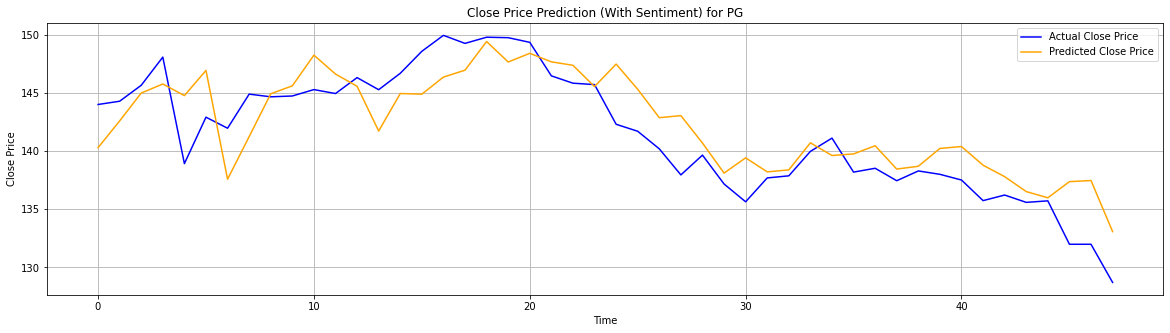

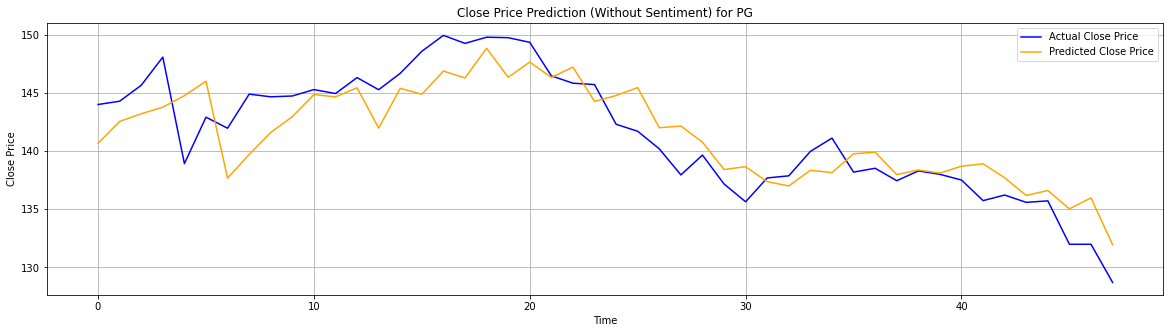

Performance of with_sentiment model for PG:
Mean Absolute Error (MAE): 2.30
Mean Squared Error (MSE): 7.88
R-squared (R²): 0.71
--------------------------------------------------
Performance of without_sentiment model for PG:
Mean Absolute Error (MAE): 2.18
Mean Squared Error (MSE): 6.78
R-squared (R²): 0.75
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             137.456923
1 2022-10-03     With Sentiment             133.068529
2 2022-09-30  Without Sentiment             135.962102
3 2022-10-03  Without Sentiment             131.941042

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for PG:
Mean Absolute Error (MAE): 1.87
Mean Squared Error (MSE): 6.10
R-squared (R²): 0.89
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for PG:
Mean Absolute Error (MAE): 1.97

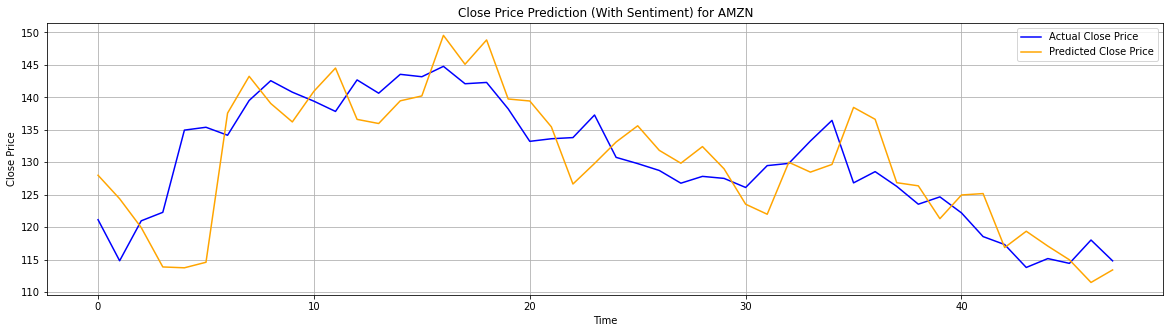

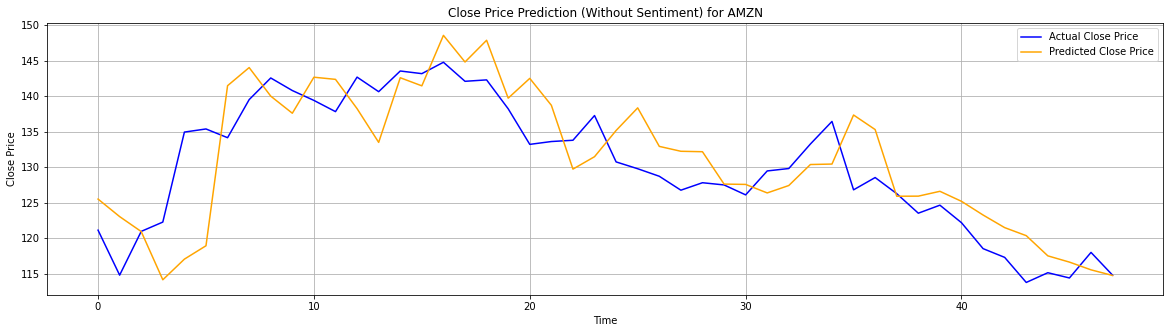

Performance of with_sentiment model for AMZN:
Mean Absolute Error (MAE): 5.05
Mean Squared Error (MSE): 43.25
R-squared (R²): 0.48
--------------------------------------------------
Performance of without_sentiment model for AMZN:
Mean Absolute Error (MAE): 4.65
Mean Squared Error (MSE): 34.47
R-squared (R²): 0.58
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             111.469715
1 2022-10-03     With Sentiment             113.400462
2 2022-09-30  Without Sentiment             115.555376
3 2022-10-03  Without Sentiment             114.761767

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for AMZN:
Mean Absolute Error (MAE): 4.17
Mean Squared Error (MSE): 23.71
R-squared (R²): 0.96
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for AMZN:
Mean Absolute Error 

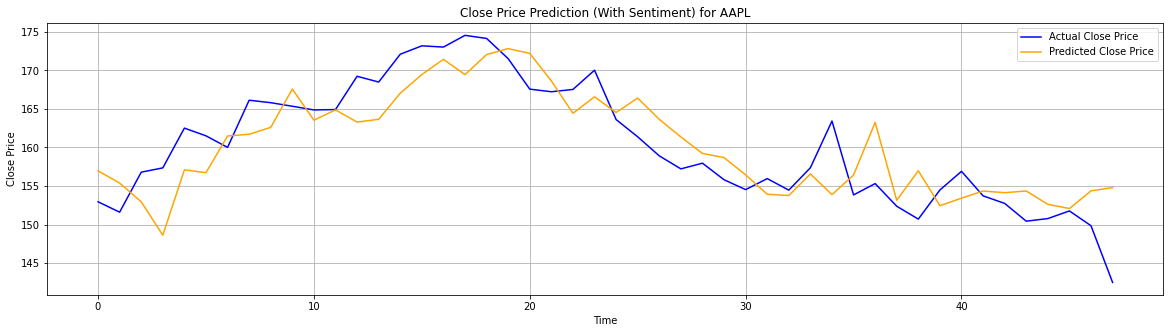

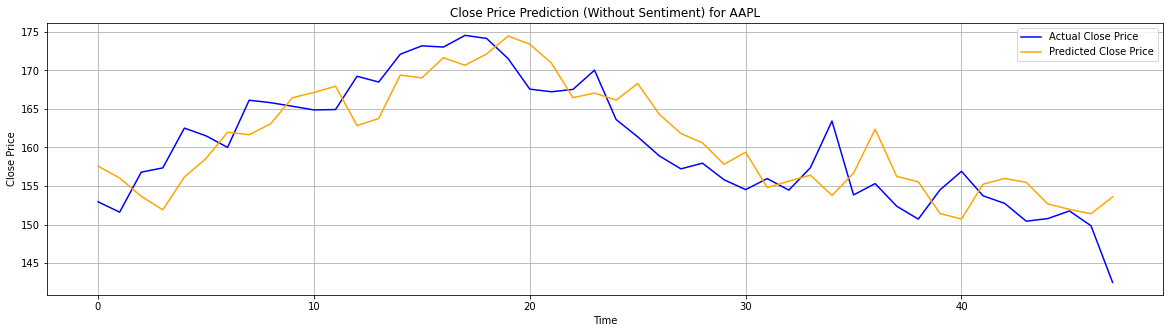

Performance of with_sentiment model for AAPL:
Mean Absolute Error (MAE): 3.49
Mean Squared Error (MSE): 18.44
R-squared (R²): 0.69
--------------------------------------------------
Performance of without_sentiment model for AAPL:
Mean Absolute Error (MAE): 3.72
Mean Squared Error (MSE): 18.72
R-squared (R²): 0.69
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             154.367010
1 2022-10-03     With Sentiment             154.788897
2 2022-09-30  Without Sentiment             151.393128
3 2022-10-03  Without Sentiment             153.582601

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for AAPL:
Mean Absolute Error (MAE): 3.26
Mean Squared Error (MSE): 16.81
R-squared (R²): 0.90
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for AAPL:
Mean Absolute Error 

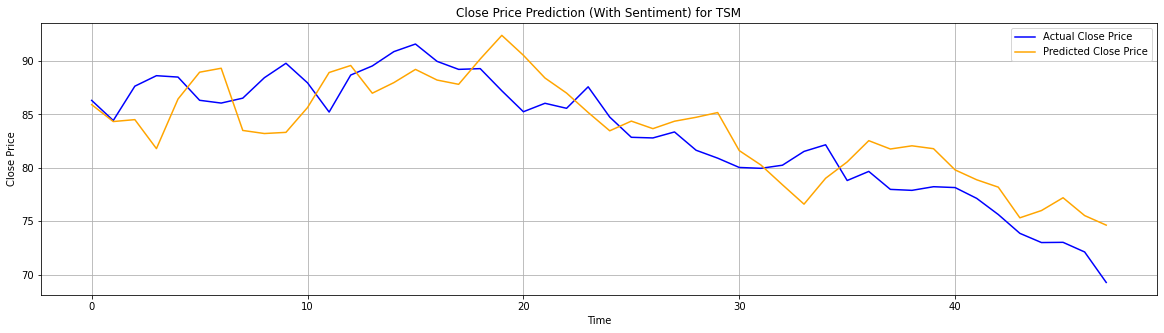

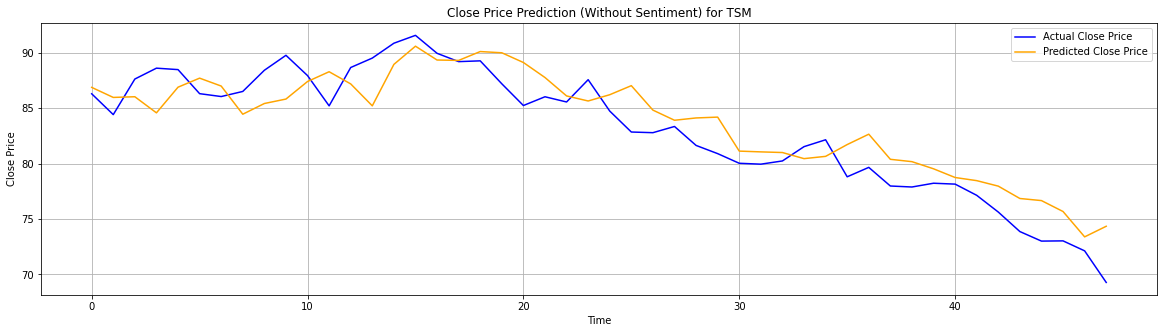

Performance of with_sentiment model for TSM:
Mean Absolute Error (MAE): 2.74
Mean Squared Error (MSE): 10.01
R-squared (R²): 0.67
--------------------------------------------------
Performance of without_sentiment model for TSM:
Mean Absolute Error (MAE): 2.02
Mean Squared Error (MSE): 5.49
R-squared (R²): 0.82
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              75.531509
1 2022-10-03     With Sentiment              74.638259
2 2022-09-30  Without Sentiment              73.391987
3 2022-10-03  Without Sentiment              74.348384

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for TSM:
Mean Absolute Error (MAE): 2.46
Mean Squared Error (MSE): 11.82
R-squared (R²): 0.95
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for TSM:
Mean Absolute Error (MAE)

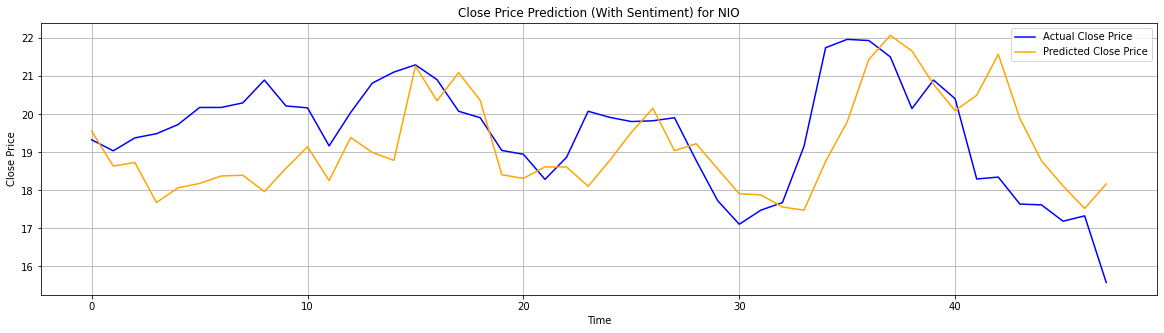

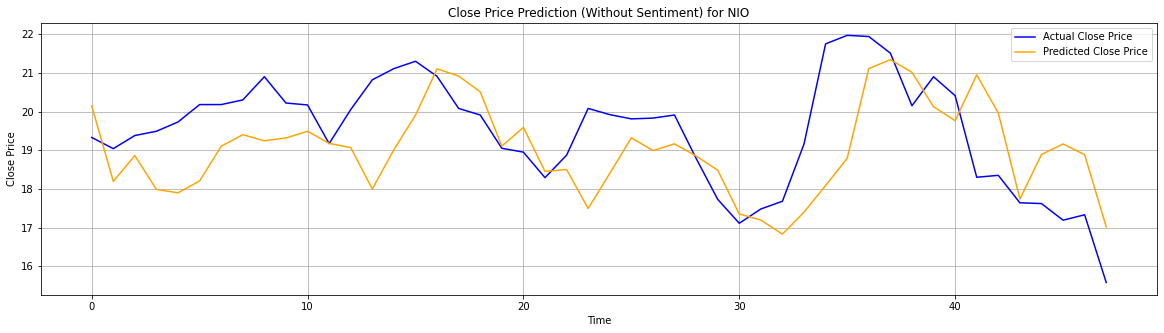

Performance of with_sentiment model for NIO:
Mean Absolute Error (MAE): 1.15
Mean Squared Error (MSE): 2.06
R-squared (R²): -0.04
--------------------------------------------------
Performance of without_sentiment model for NIO:
Mean Absolute Error (MAE): 1.12
Mean Squared Error (MSE): 1.97
R-squared (R²): 0.00
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              17.524803
1 2022-10-03     With Sentiment              18.169713
2 2022-09-30  Without Sentiment              18.884871
3 2022-10-03  Without Sentiment              17.017995

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for NIO:
Mean Absolute Error (MAE): 1.27
Mean Squared Error (MSE): 2.59
R-squared (R²): 0.96
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for NIO:
Mean Absolute Error (MAE):

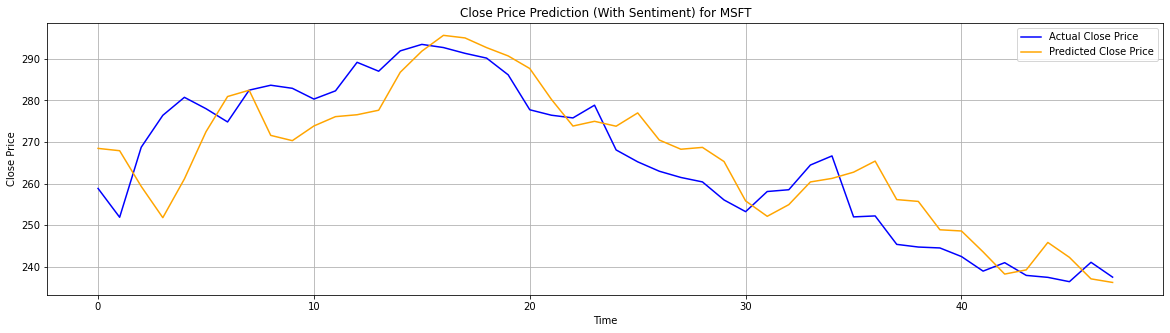

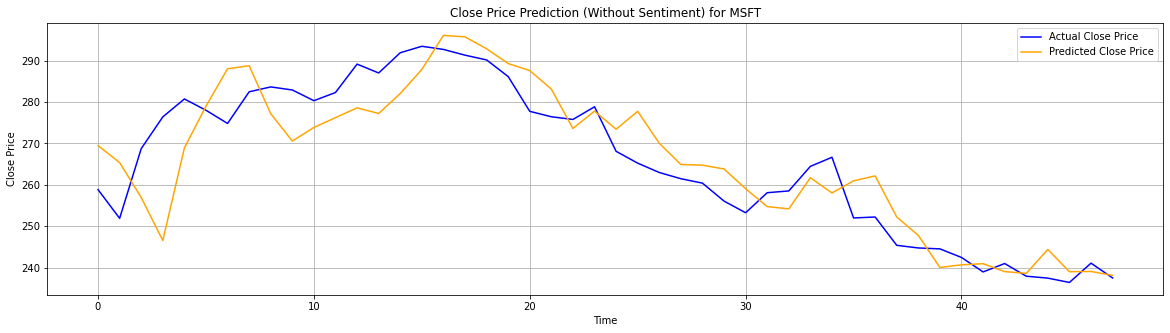

Performance of with_sentiment model for MSFT:
Mean Absolute Error (MAE): 7.20
Mean Squared Error (MSE): 75.03
R-squared (R²): 0.77
--------------------------------------------------
Performance of without_sentiment model for MSFT:
Mean Absolute Error (MAE): 6.58
Mean Squared Error (MSE): 68.41
R-squared (R²): 0.79
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             237.087271
1 2022-10-03     With Sentiment             236.225853
2 2022-09-30  Without Sentiment             239.058289
3 2022-10-03  Without Sentiment             238.120322

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for MSFT:
Mean Absolute Error (MAE): 5.84
Mean Squared Error (MSE): 49.30
R-squared (R²): 0.94
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for MSFT:
Mean Absolute Error 

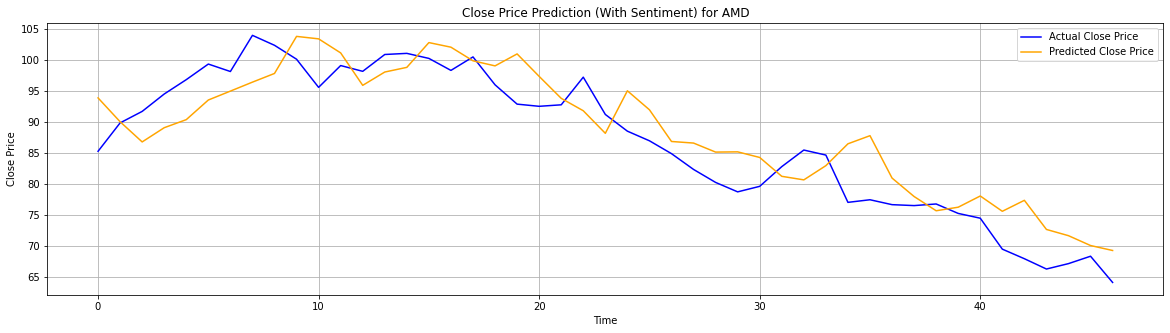

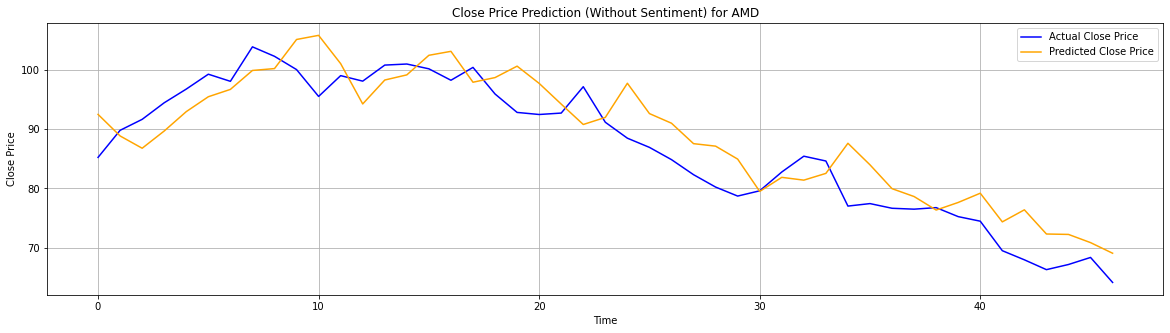

Performance of with_sentiment model for AMD:
Mean Absolute Error (MAE): 4.38
Mean Squared Error (MSE): 25.42
R-squared (R²): 0.80
--------------------------------------------------
Performance of without_sentiment model for AMD:
Mean Absolute Error (MAE): 4.28
Mean Squared Error (MSE): 24.79
R-squared (R²): 0.81
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              70.082380
1 2022-10-03     With Sentiment              69.283388
2 2022-09-30  Without Sentiment              70.863094
3 2022-10-03  Without Sentiment              69.068910

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for AMD:
Mean Absolute Error (MAE): 4.89
Mean Squared Error (MSE): 32.44
R-squared (R²): 0.94
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for AMD:
Mean Absolute Error (MAE

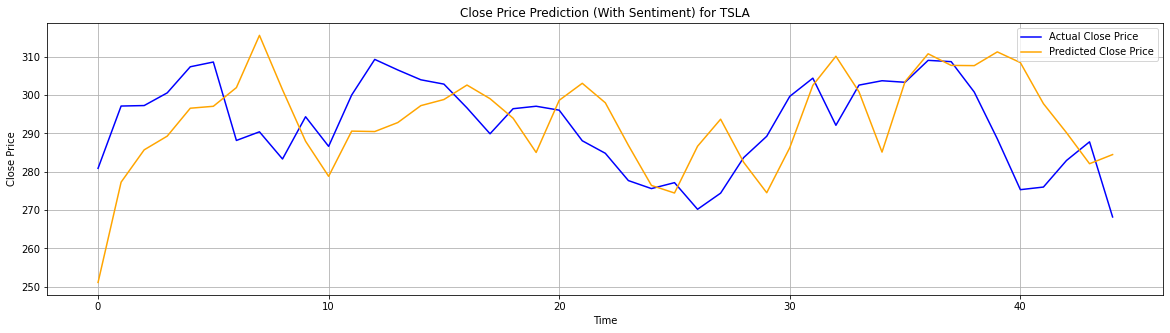

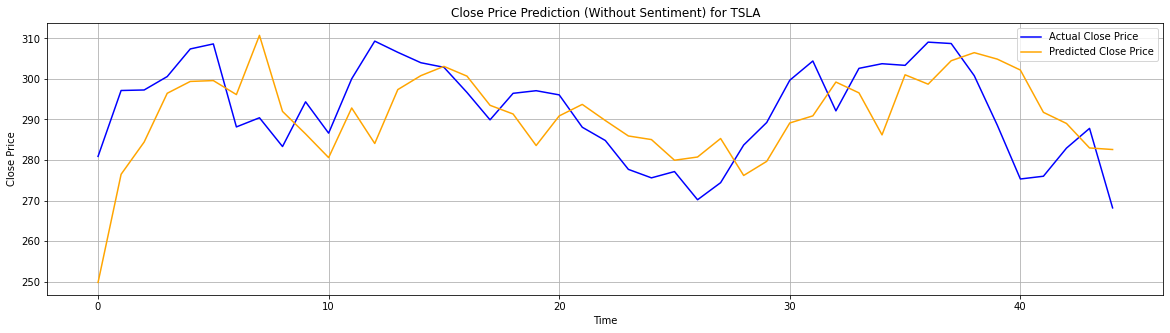

Performance of with_sentiment model for TSLA:
Mean Absolute Error (MAE): 11.42
Mean Squared Error (MSE): 193.64
R-squared (R²): -0.48
--------------------------------------------------
Performance of without_sentiment model for TSLA:
Mean Absolute Error (MAE): 9.87
Mean Squared Error (MSE): 141.58
R-squared (R²): -0.08
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             282.099247
1 2022-10-03     With Sentiment             284.485559
2 2022-09-30  Without Sentiment             282.980430
3 2022-10-03  Without Sentiment             282.598276

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for TSLA:
Mean Absolute Error (MAE): 12.75
Mean Squared Error (MSE): 258.22
R-squared (R²): 0.89
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for TSLA:
Mean Absolute

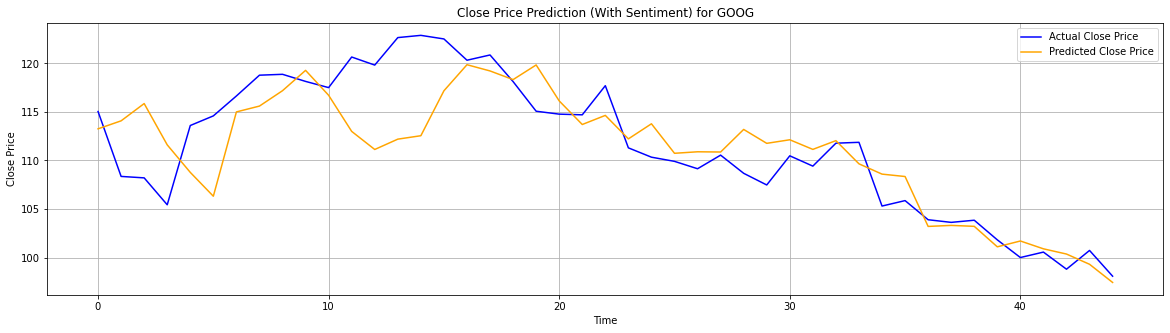

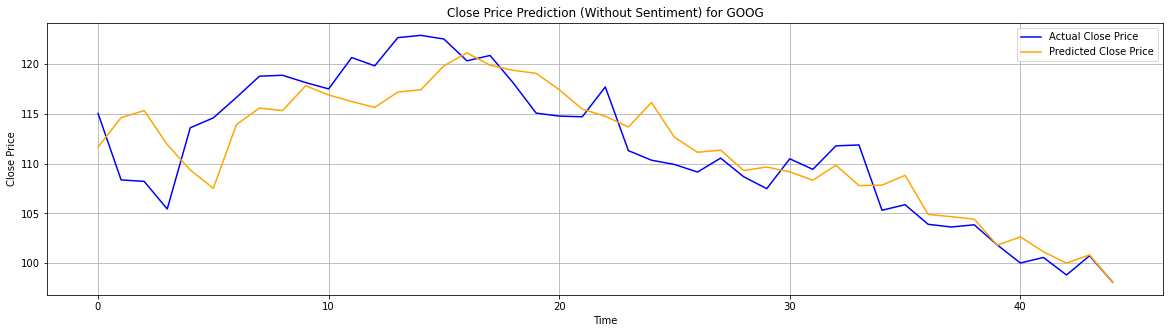

Performance of with_sentiment model for GOOG:
Mean Absolute Error (MAE): 2.97
Mean Squared Error (MSE): 16.67
R-squared (R²): 0.66
--------------------------------------------------
Performance of without_sentiment model for GOOG:
Mean Absolute Error (MAE): 2.62
Mean Squared Error (MSE): 10.82
R-squared (R²): 0.78
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              99.315599
1 2022-10-03     With Sentiment              97.445856
2 2022-09-30  Without Sentiment             100.829786
3 2022-10-03  Without Sentiment              98.059729

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for GOOG:
Mean Absolute Error (MAE): 2.99
Mean Squared Error (MSE): 12.21
R-squared (R²): 0.93
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for GOOG:
Mean Absolute Error 

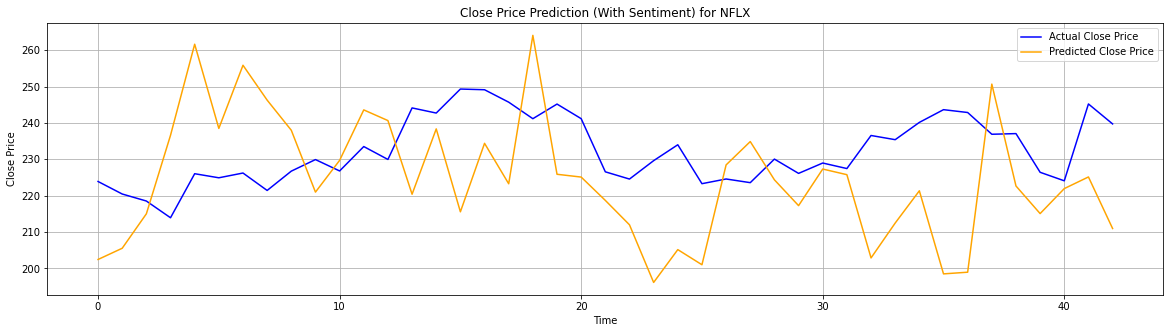

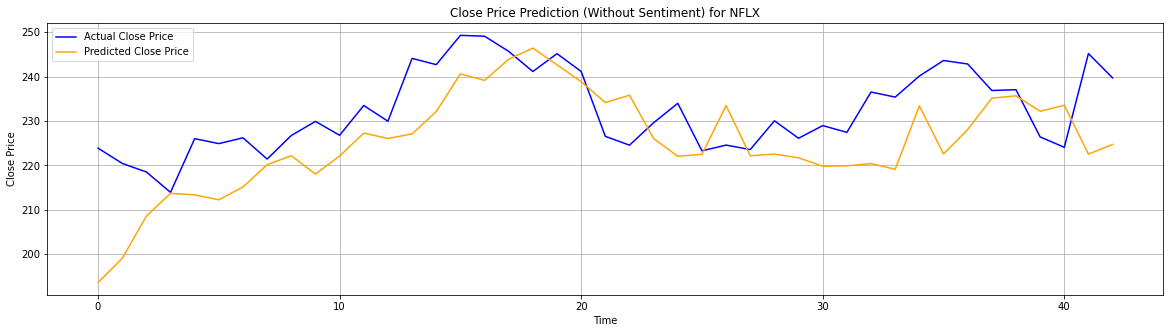

Performance of with_sentiment model for NFLX:
Mean Absolute Error (MAE): 17.68
Mean Squared Error (MSE): 438.43
R-squared (R²): -4.42
--------------------------------------------------
Performance of without_sentiment model for NFLX:
Mean Absolute Error (MAE): 9.16
Mean Squared Error (MSE): 128.17
R-squared (R²): -0.58
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             225.129883
1 2022-10-03     With Sentiment             210.954403
2 2022-09-30  Without Sentiment             222.547022
3 2022-10-03  Without Sentiment             224.722558

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for NFLX:
Mean Absolute Error (MAE): 22.58
Mean Squared Error (MSE): 700.12
R-squared (R²): 0.98
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for NFLX:
Mean Absolute

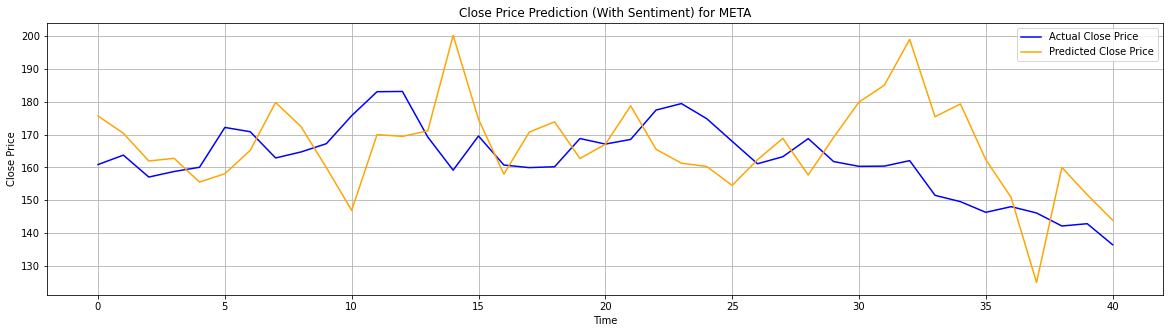

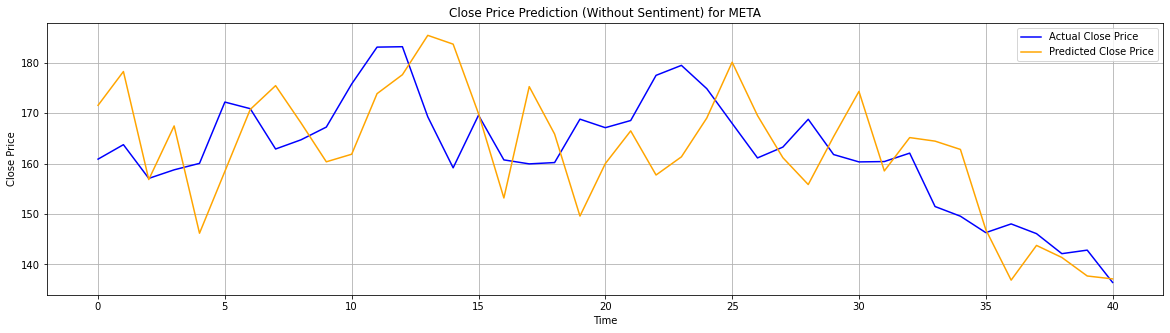

Performance of with_sentiment model for META:
Mean Absolute Error (MAE): 12.85
Mean Squared Error (MSE): 253.62
R-squared (R²): -1.19
--------------------------------------------------
Performance of without_sentiment model for META:
Mean Absolute Error (MAE): 8.78
Mean Squared Error (MSE): 116.73
R-squared (R²): -0.01
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             151.660749
1 2022-10-03     With Sentiment             143.894114
2 2022-09-30  Without Sentiment             137.690512
3 2022-10-03  Without Sentiment             137.113148

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for META:
Mean Absolute Error (MAE): 7.01
Mean Squared Error (MSE): 166.74
R-squared (R²): 0.96
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for META:
Mean Absolute 

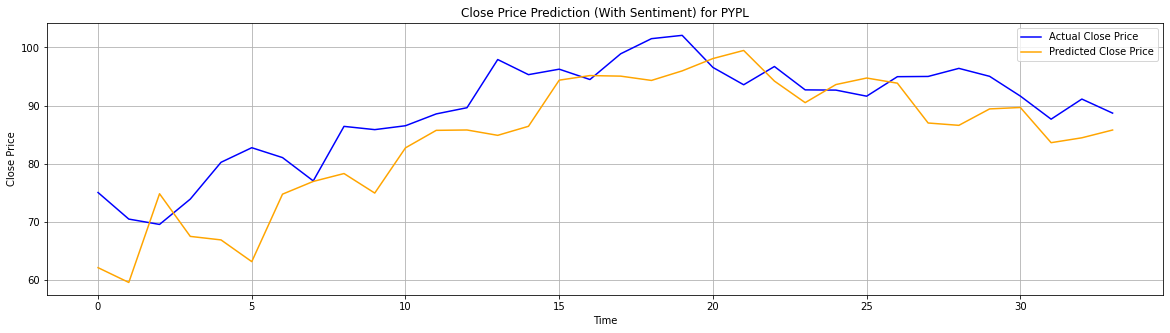

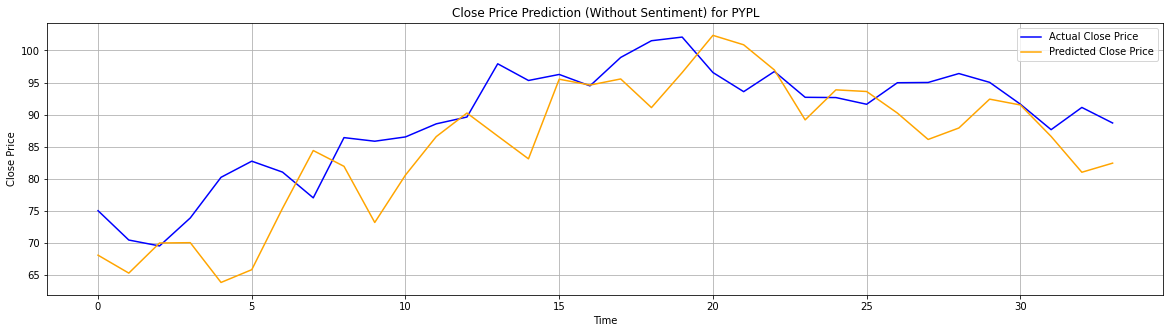

Performance of with_sentiment model for PYPL:
Mean Absolute Error (MAE): 5.95
Mean Squared Error (MSE): 54.73
R-squared (R²): 0.24
--------------------------------------------------
Performance of without_sentiment model for PYPL:
Mean Absolute Error (MAE): 5.71
Mean Squared Error (MSE): 53.00
R-squared (R²): 0.27
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              84.454864
1 2022-10-03     With Sentiment              85.794254
2 2022-09-30  Without Sentiment              81.028163
3 2022-10-03  Without Sentiment              82.444847

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for PYPL:
Mean Absolute Error (MAE): 4.43
Mean Squared Error (MSE): 55.77
R-squared (R²): 0.98
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for PYPL:
Mean Absolute Error 

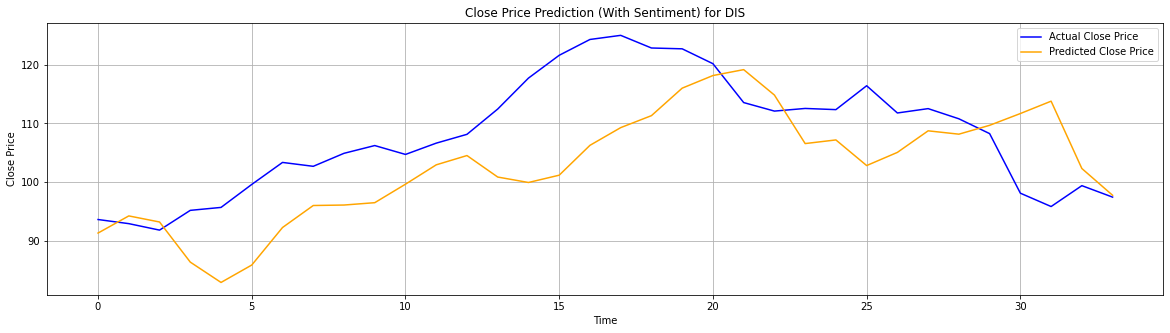

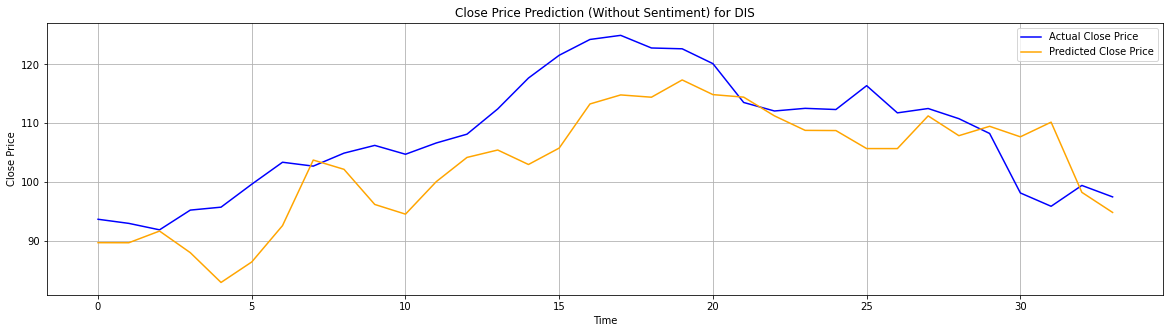

Performance of with_sentiment model for DIS:
Mean Absolute Error (MAE): 8.08
Mean Squared Error (MSE): 97.36
R-squared (R²): -0.03
--------------------------------------------------
Performance of without_sentiment model for DIS:
Mean Absolute Error (MAE): 6.55
Mean Squared Error (MSE): 63.83
R-squared (R²): 0.33
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             102.315529
1 2022-10-03     With Sentiment              97.762628
2 2022-09-30  Without Sentiment              98.225642
3 2022-10-03  Without Sentiment              94.801915

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for DIS:
Mean Absolute Error (MAE): 2.90
Mean Squared Error (MSE): 12.78
R-squared (R²): 0.98
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for DIS:
Mean Absolute Error (MA

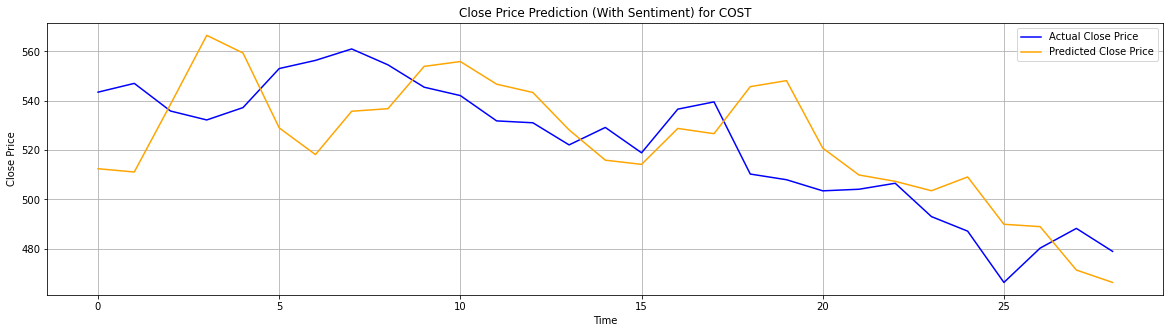

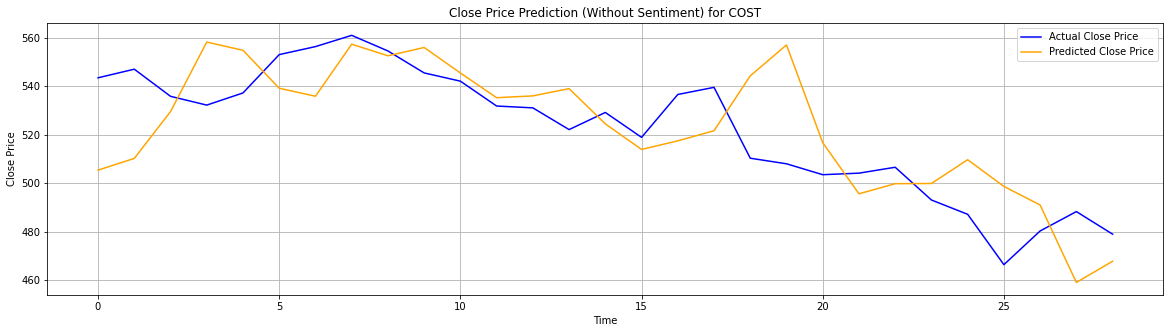

Performance of with_sentiment model for COST:
Mean Absolute Error (MAE): 17.89
Mean Squared Error (MSE): 443.41
R-squared (R²): 0.33
--------------------------------------------------
Performance of without_sentiment model for COST:
Mean Absolute Error (MAE): 16.37
Mean Squared Error (MSE): 419.52
R-squared (R²): 0.36
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             471.423696
1 2022-10-03     With Sentiment             466.402522
2 2022-09-30  Without Sentiment             459.072136
3 2022-10-03  Without Sentiment             467.816396

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for COST:
Mean Absolute Error (MAE): 10.05
Mean Squared Error (MSE): 204.98
R-squared (R²): 0.88
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for COST:
Mean Absolute 

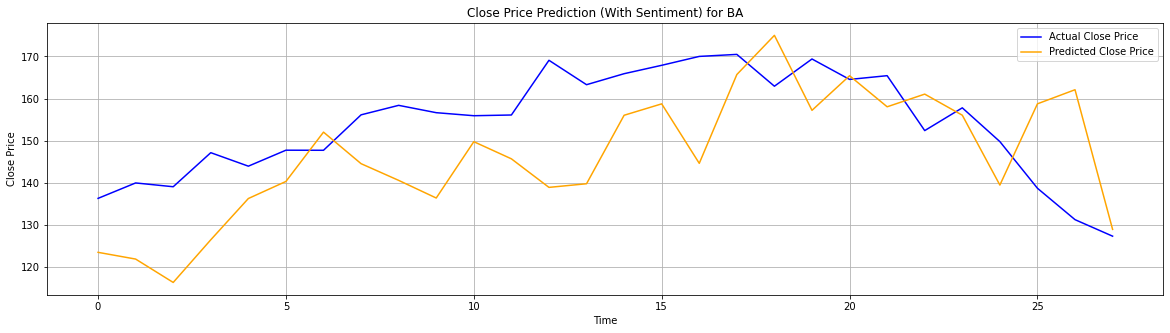

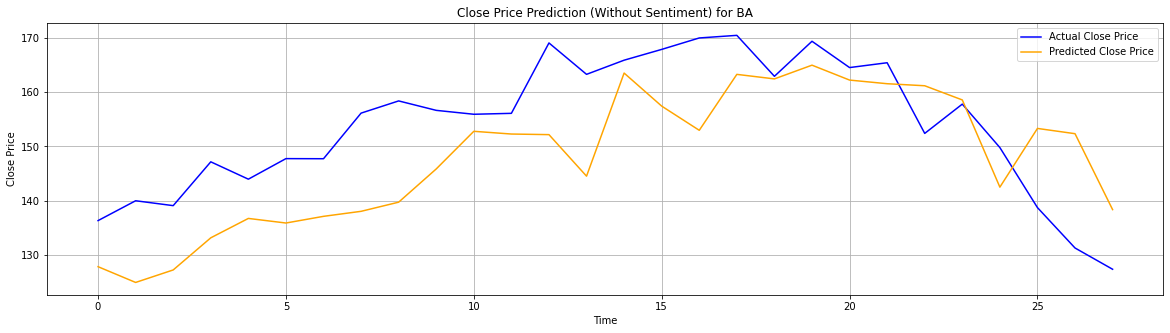

Performance of with_sentiment model for BA:
Mean Absolute Error (MAE): 13.15
Mean Squared Error (MSE): 241.73
R-squared (R²): -0.60
--------------------------------------------------
Performance of without_sentiment model for BA:
Mean Absolute Error (MAE): 10.04
Mean Squared Error (MSE): 135.87
R-squared (R²): 0.10
--------------------------------------------------
        Date              Model  Predicted Close Price
0 2022-09-27     With Sentiment             162.084780
1 2022-09-28     With Sentiment             128.954074
2 2022-09-27  Without Sentiment             152.337291
3 2022-09-28  Without Sentiment             138.336860

Train performance of with_sentiment model:
Performance of with_sentiment (Train) model for BA:
Mean Absolute Error (MAE): 6.30
Mean Squared Error (MSE): 56.29
R-squared (R²): 0.94
--------------------------------------------------

Train performance of without_sentiment model:
Performance of without_sentiment (Train) model for BA:
Mean Absolute Error (MA

In [159]:
#Count the number of occurrences of each stock in the merged_data
stock_counts = merged_data['Stock Name'].value_counts()

# Filter stocks that have more than 100 entries
filtered_stocks = stock_counts[stock_counts > 150].index

# Loop through the filtered stocks and call the predict_stock_price_gru function
for stock in filtered_stocks:
    predict_stock_price(merged_data, stock)

### Gated recurrent unit


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict_stock_price_gru(merged_data, stock_name, n_past=15, n_future=1):
    # Make a copy of the DataFrame to avoid modifying the original
    data_copy = merged_data.copy()
    
    # Check if 'Date' column exists
    if 'Date' not in data_copy.columns:
        print("The 'Date' column is missing from merged_data.")
        return  # Exit the function if 'Date' is not found
    
    # Convert 'Date' column to datetime format
    data_copy['Date'] = pd.to_datetime(data_copy['Date'])
    
    # Filter data for the specified stock
    stock_data = merged_data[merged_data['Stock Name'] == stock_name]

    # Define the feature columns for the two models
    feature_columns = {
        "with_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Sentiment_Score'],
        "without_sentiment": ['Open', 'High', 'Low', 'Close', 'Adj Close']
    }

    # Create two separate DataFrames: one with sentiment features and one without
    dataframes = {
        "with_sentiment": stock_data[feature_columns["with_sentiment"]].astype(float),
        "without_sentiment": stock_data[feature_columns["without_sentiment"]].astype(float)
    }

    # Standardize the data using MinMaxScaler
    scalers = {
        "with_sentiment": MinMaxScaler(),
        "without_sentiment": MinMaxScaler()
    }
    scaled_data = {key: scalers[key].fit_transform(dataframes[key]) for key in dataframes}

    # Define a function to create input sequences (X) and targets (y) for the model
    def create_features_and_target(data, n_past, n_future, target_col_idx):
        X, y = [], []
        for i in range(n_past, len(data) - n_future + 1):
            X.append(data[i - n_past:i, :])  # Use the past 'n_past' days of data
            y.append(data[i + n_future - 1, target_col_idx])  # Predict 'n_future' days ahead
        return np.array(X), np.array(y)

    # Create input (X) and output (y) pairs for both datasets
    X_y_data = {key: create_features_and_target(scaled_data[key], n_past, n_future, 3) for key in scaled_data}

    # Split the data into training and testing sets
    X_train_test_data = {
        key: train_test_split(X, y, test_size=0.2, shuffle=False)
        for key, (X, y) in X_y_data.items()
    }

    # Define a function to create and compile the GRU model
    def create_gru_model(input_shape):
        model = Sequential()
        model.add(GRU(700, return_sequences=True, input_shape=input_shape))  # First layer
        model.add(Dropout(0.1))
        model.add(GRU(350, return_sequences=True))  # Second layer, return sequences
        model.add(Dropout(0.1))
        model.add(GRU(150, return_sequences=False))  # Third layer, no return sequences
        model.add(Dropout(0.1))
        model.add(Dense(1))  # Output layer
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
 
    # Train the GRU model for each dataset
    gru_models = {}
    histories = {}  # To store training history
    for key, (X_train, X_test, y_train, y_test) in X_train_test_data.items():
        model = create_gru_model((X_train.shape[1], X_train.shape[2]))
        
        # Early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        
        # Fit the model and store the training history
        history = model.fit(X_train, y_train, 
                            validation_data=(X_test, y_test), 
                            epochs=250, 
                            batch_size=64, 
                            callbacks=[early_stopping], 
                            verbose=0)
        
        gru_models[key] = model
        histories[key] = history  # Store the history

    # Make predictions using the trained models
    predictions = {
        key: model.predict(X_test)
        for key, model in gru_models.items()
        for (X_train, X_test, y_train, y_test) in [X_train_test_data[key]]
    }

    # Define a function to reverse the scaling
    def inverse_transform(scaler, y_pred, y_test, data_shape):
        y_pred_unscaled = np.full((y_pred.shape[0], data_shape[1]), np.nan)
        y_test_unscaled = np.full((y_test.shape[0], data_shape[1]), np.nan)
        
        y_pred_unscaled[:, 0] = y_pred.flatten()
        y_test_unscaled[:, 0] = y_test
        
        return (scaler.inverse_transform(y_pred_unscaled), scaler.inverse_transform(y_test_unscaled))

    # Reverse the scaling for predictions and actual values
    unscaled_results = {
        key: inverse_transform(scalers[key], predictions[key], y_test, dataframes[key].shape)
        for key, (_, _, y_train, y_test) in X_train_test_data.items()
    }

    # Define a function to plot the predictions vs actual values
    def plot_predictions(unscaled_data, title):
        plt.figure(figsize=(20, 5))
        plt.plot(unscaled_data[1][:, 0], label='Actual Close Price', color='blue') 
        plt.plot(unscaled_data[0][:, 0], label='Predicted Close Price', color='orange')  
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the predictions vs actual values for both models
    plot_predictions(unscaled_results["with_sentiment"], f'Close Price Prediction (With Sentiment) for {stock_name}')
    plot_predictions(unscaled_results["without_sentiment"], f'Close Price Prediction (Without Sentiment) for {stock_name}')
    
    # Evaluate performance for each model
    for key in unscaled_results:
        y_true = unscaled_results[key][1][:, 0]
        y_pred = unscaled_results[key][0][:, 0]
        evaluate_model_performance(y_true, y_pred, stock_name, key)

    # Print future predictions and their dates
    last_date = stock_data['Date'].max()  # Get the last date in the stock data
    future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Generate future business days
    future_predictions = {
        key: unscaled_results[key][0][-n_future:, 0] for key in unscaled_results
    }
    
    # Create DataFrame to display future predictions
    future_results_df = pd.DataFrame({
        'Date': np.tile(future_dates, 2),
        'Model': ['With Sentiment'] * n_future + ['Without Sentiment'] * n_future,
        'Predicted Close Price': np.concatenate(list(future_predictions.values()))
    })

    print(future_results_df)

    # Plot training and validation loss for each model
    for key, history in histories.items():
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss ({key}) for {stock_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

def evaluate_model_performance(y_true, y_pred, stock_name, model_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Performance of {model_type} model for {stock_name}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.2f}\n")

2/2 [==============================] - 1s 31ms/step


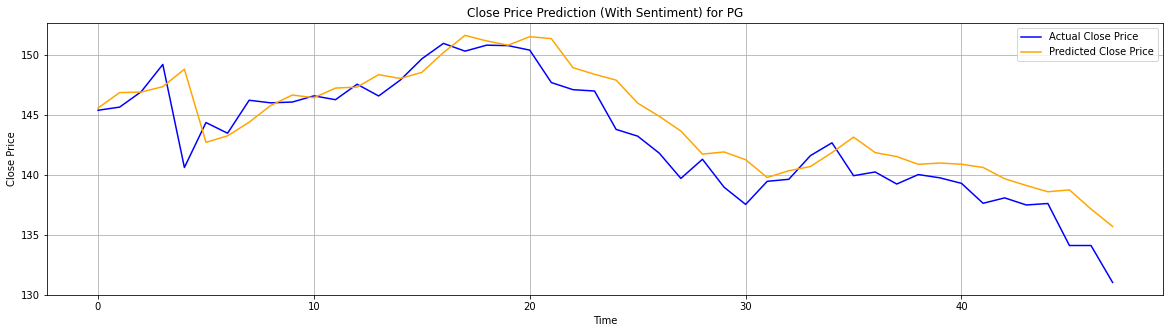

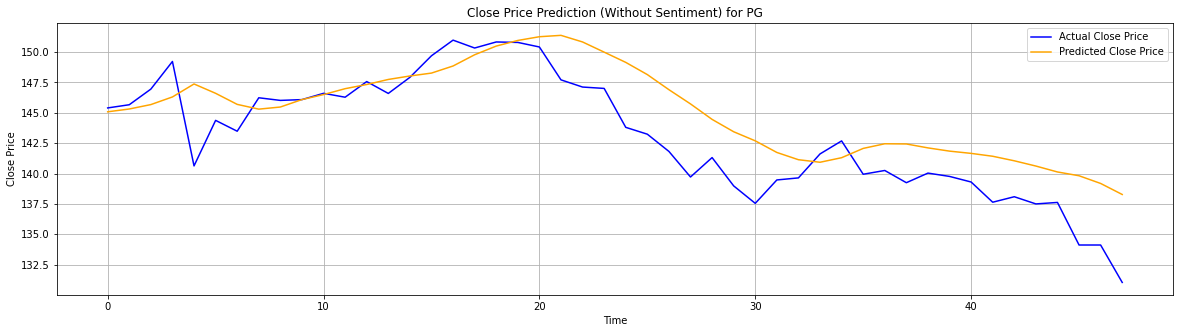

Performance of with_sentiment model for PG:
Mean Absolute Error (MAE): 1.77
Mean Squared Error (MSE): 5.66
R-squared (R²): 0.76

Performance of without_sentiment model for PG:
Mean Absolute Error (MAE): 2.50
Mean Squared Error (MSE): 9.94
R-squared (R²): 0.58

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             135.703589
1 2022-09-30  Without Sentiment             138.272365


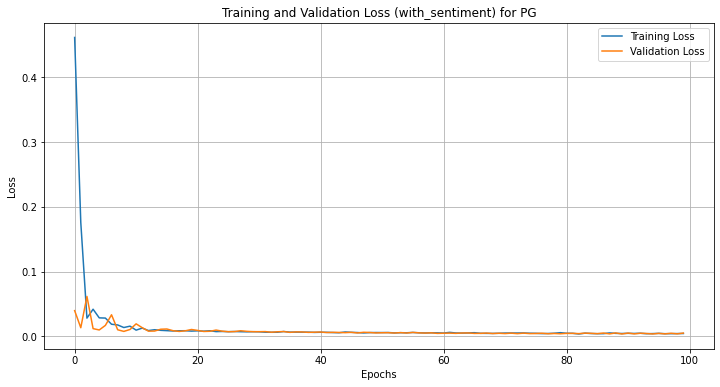

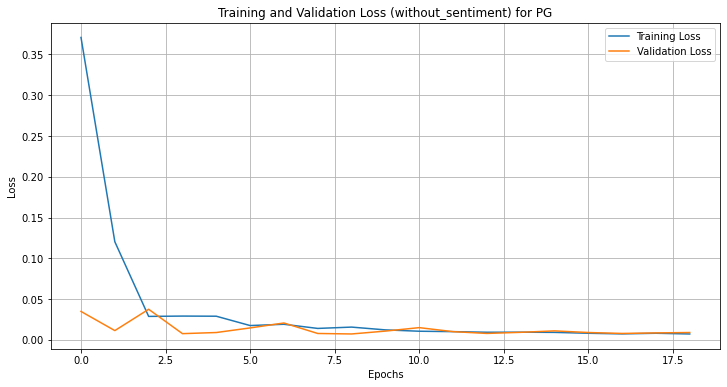

2/2 [==============================] - 1s 32ms/step


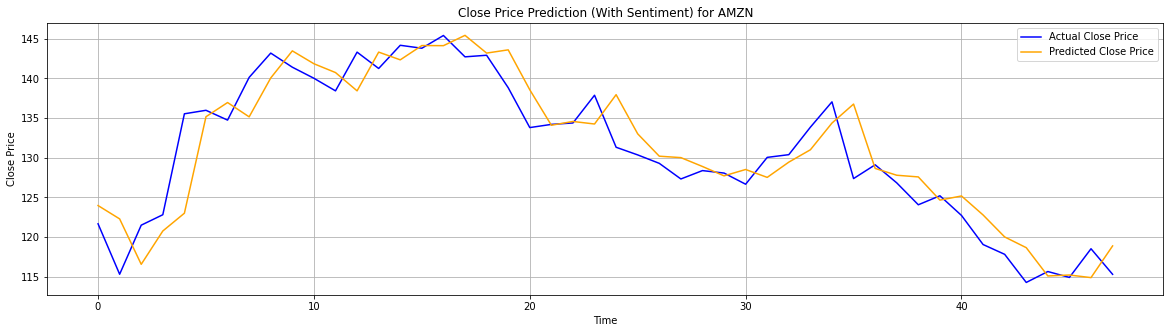

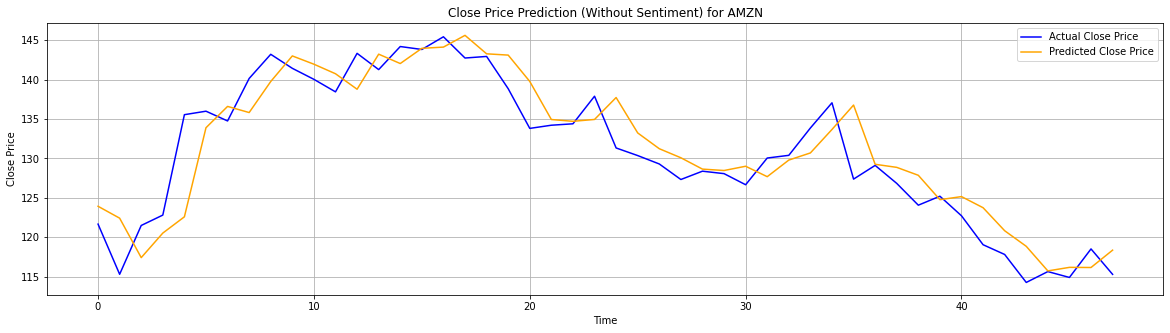

Performance of with_sentiment model for AMZN:
Mean Absolute Error (MAE): 2.78
Mean Squared Error (MSE): 13.55
R-squared (R²): 0.84

Performance of without_sentiment model for AMZN:
Mean Absolute Error (MAE): 2.86
Mean Squared Error (MSE): 14.00
R-squared (R²): 0.83

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             118.880869
1 2022-09-30  Without Sentiment             118.368747


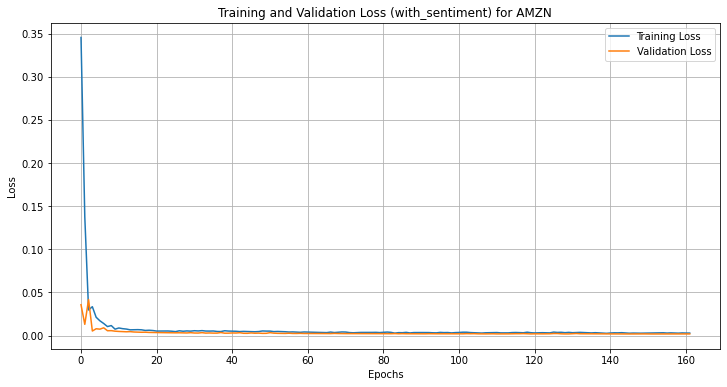

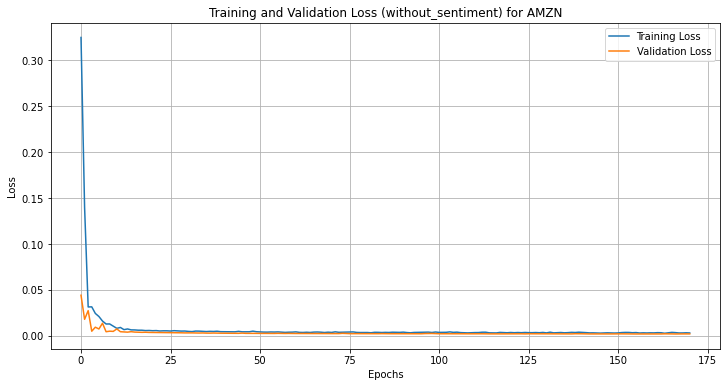

2/2 [==============================] - 1s 30ms/step


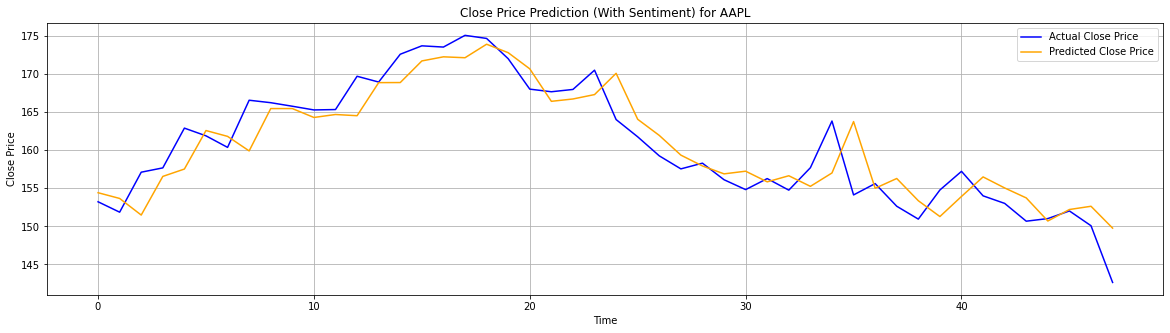

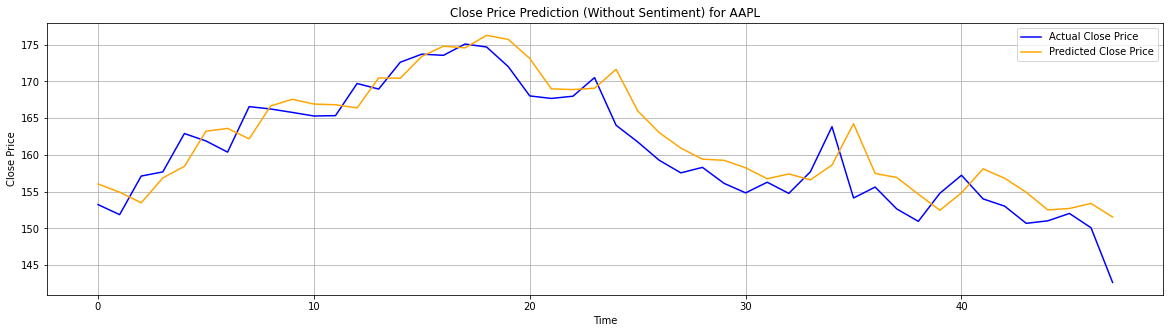

Performance of with_sentiment model for AAPL:
Mean Absolute Error (MAE): 2.51
Mean Squared Error (MSE): 10.83
R-squared (R²): 0.82

Performance of without_sentiment model for AAPL:
Mean Absolute Error (MAE): 2.90
Mean Squared Error (MSE): 12.66
R-squared (R²): 0.79

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             149.768399
1 2022-09-30  Without Sentiment             151.540161


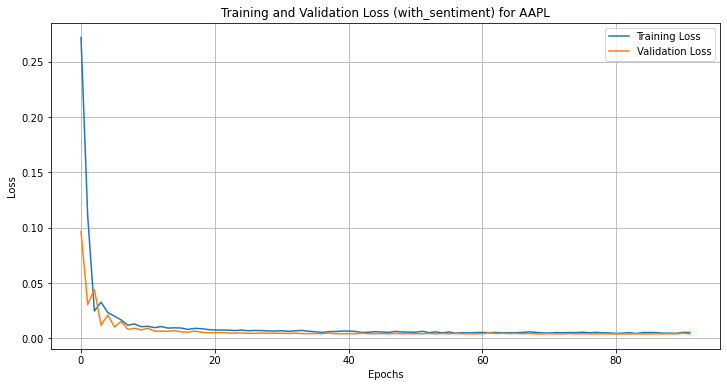

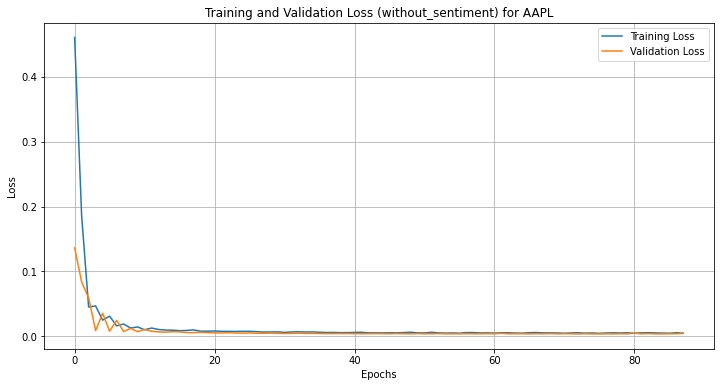

2/2 [==============================] - 1s 32ms/step


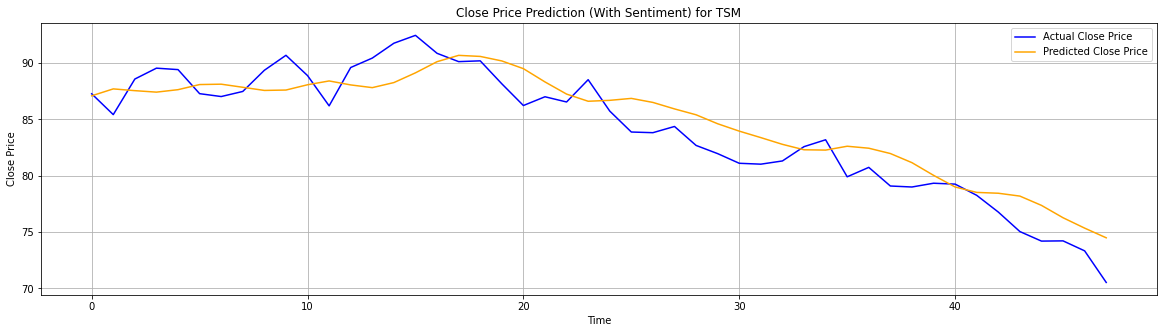

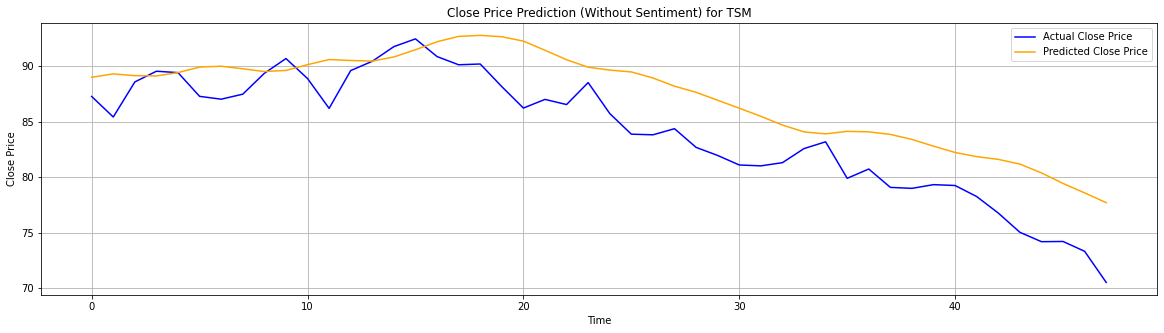

Performance of with_sentiment model for TSM:
Mean Absolute Error (MAE): 1.83
Mean Squared Error (MSE): 4.37
R-squared (R²): 0.85

Performance of without_sentiment model for TSM:
Mean Absolute Error (MAE): 3.25
Mean Squared Error (MSE): 14.20
R-squared (R²): 0.52

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              74.482055
1 2022-09-30  Without Sentiment              77.704206


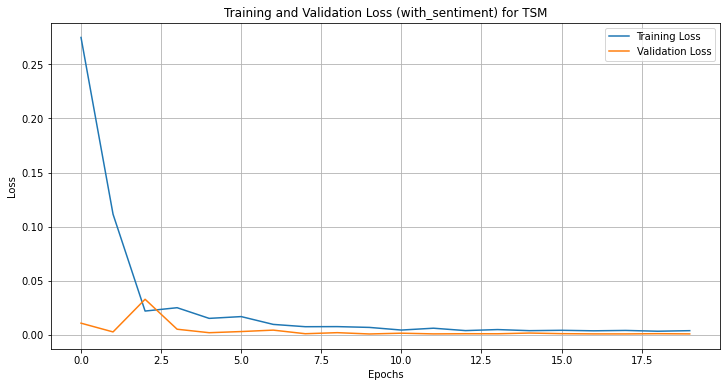

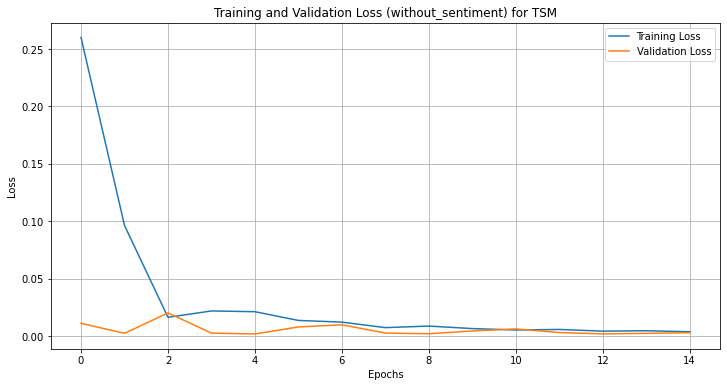

2/2 [==============================] - 1s 40ms/step


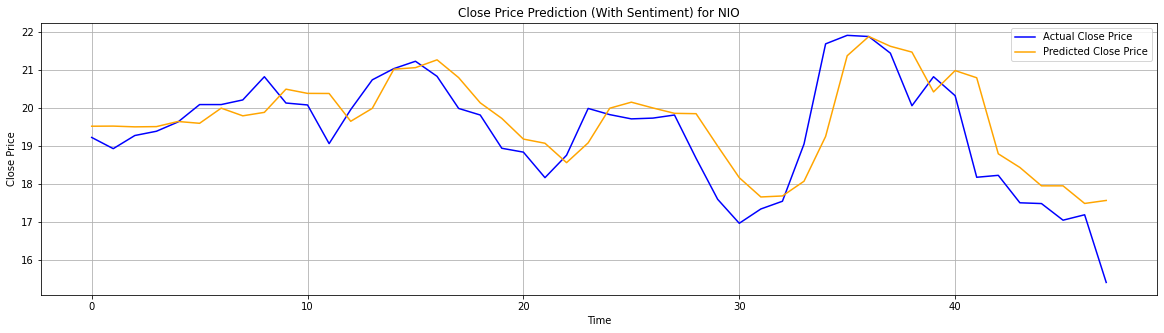

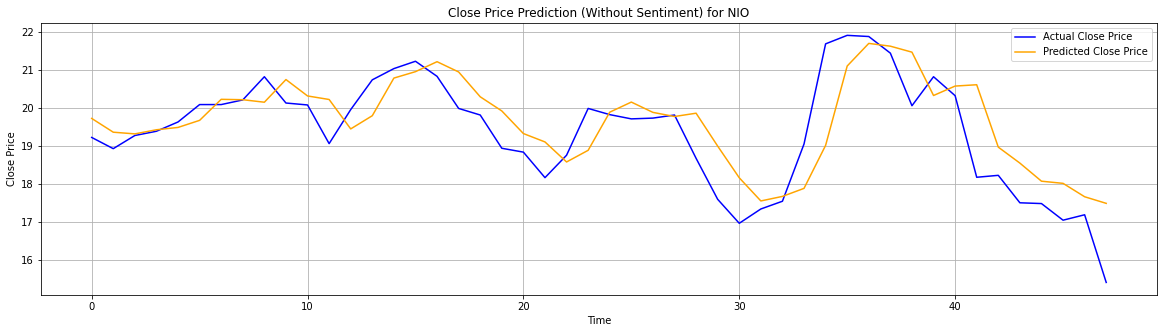

Performance of with_sentiment model for NIO:
Mean Absolute Error (MAE): 0.64
Mean Squared Error (MSE): 0.76
R-squared (R²): 0.63

Performance of without_sentiment model for NIO:
Mean Absolute Error (MAE): 0.67
Mean Squared Error (MSE): 0.81
R-squared (R²): 0.60

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              17.560625
1 2022-09-30  Without Sentiment              17.483944


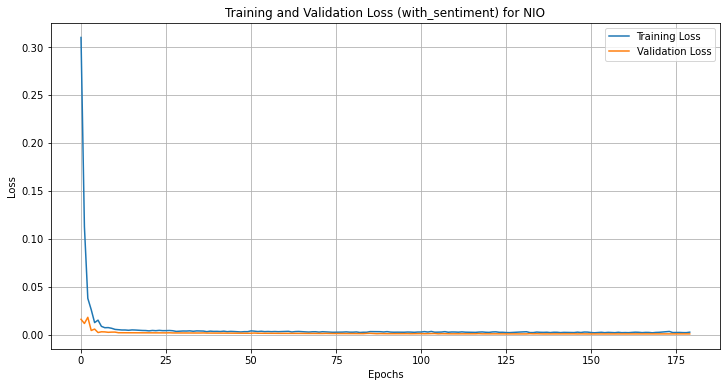

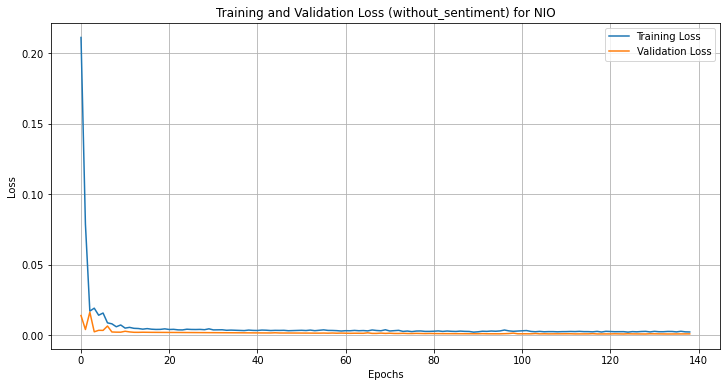

2/2 [==============================] - 1s 33ms/step


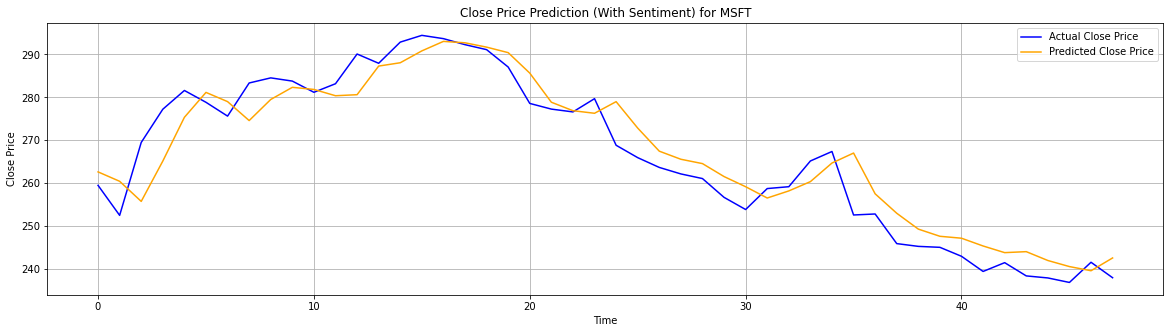

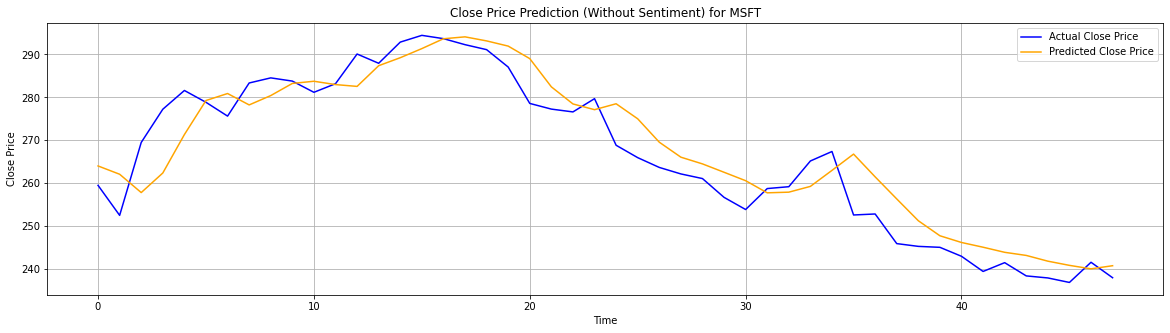

Performance of with_sentiment model for MSFT:
Mean Absolute Error (MAE): 4.53
Mean Squared Error (MSE): 31.42
R-squared (R²): 0.90

Performance of without_sentiment model for MSFT:
Mean Absolute Error (MAE): 5.01
Mean Squared Error (MSE): 38.08
R-squared (R²): 0.88

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             242.525458
1 2022-09-30  Without Sentiment             240.714382


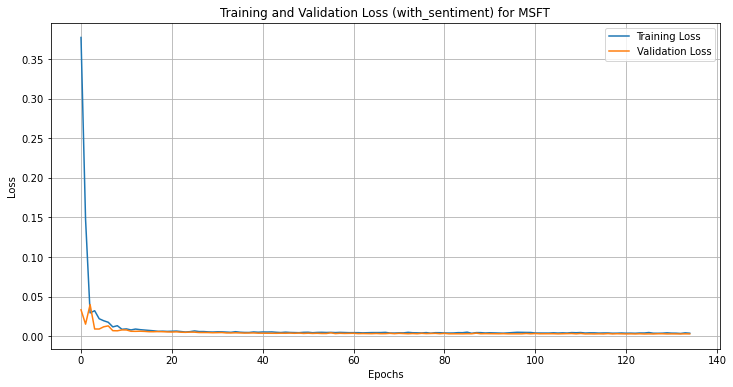

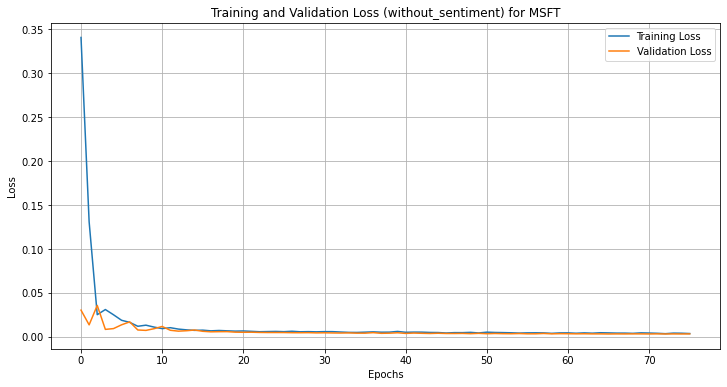

2/2 [==============================] - 1s 26ms/step


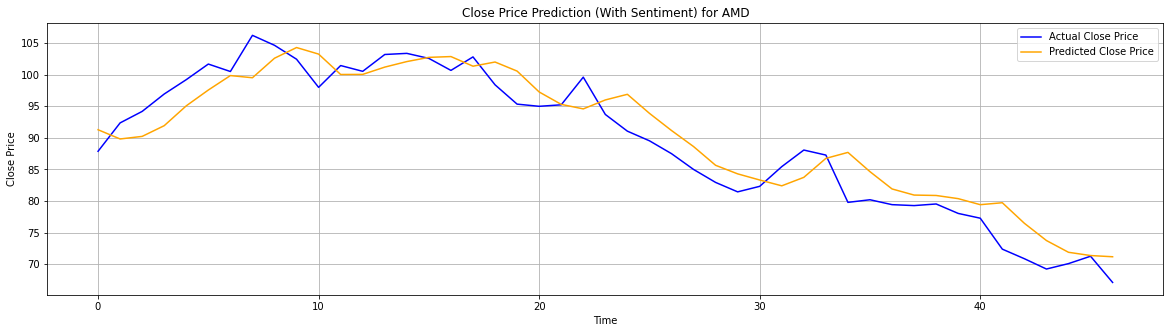

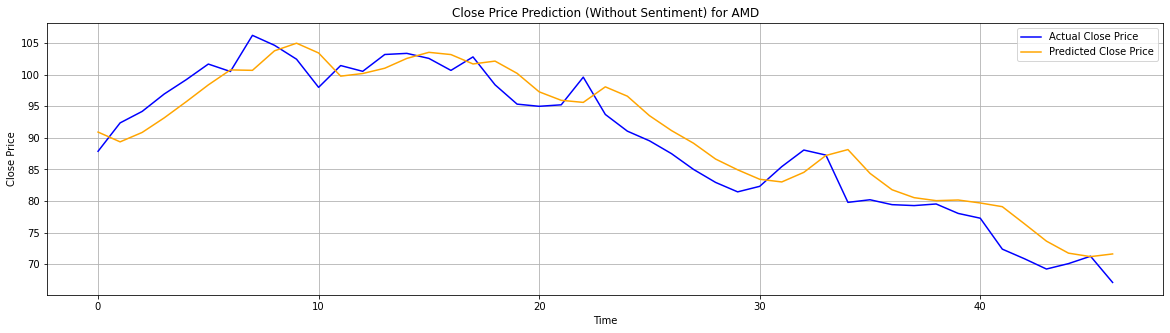

Performance of with_sentiment model for AMD:
Mean Absolute Error (MAE): 3.08
Mean Squared Error (MSE): 13.14
R-squared (R²): 0.89

Performance of without_sentiment model for AMD:
Mean Absolute Error (MAE): 2.98
Mean Squared Error (MSE): 12.25
R-squared (R²): 0.90

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              71.177120
1 2022-09-30  Without Sentiment              71.622991


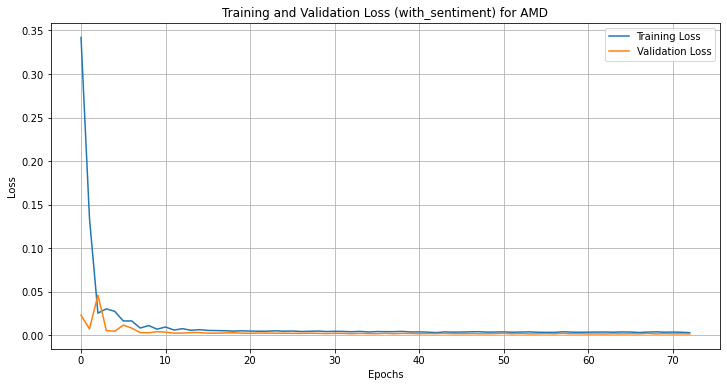

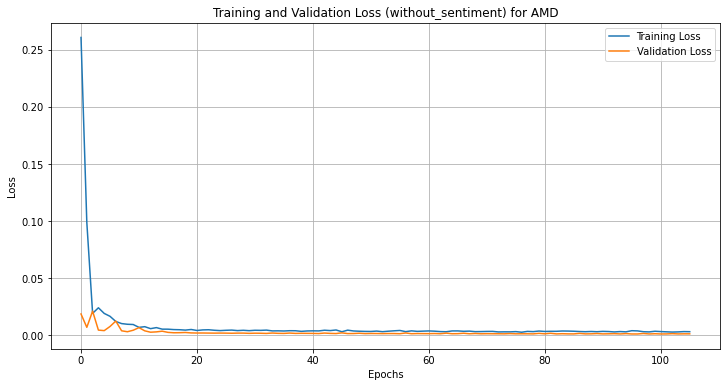

2/2 [==============================] - 1s 26ms/step


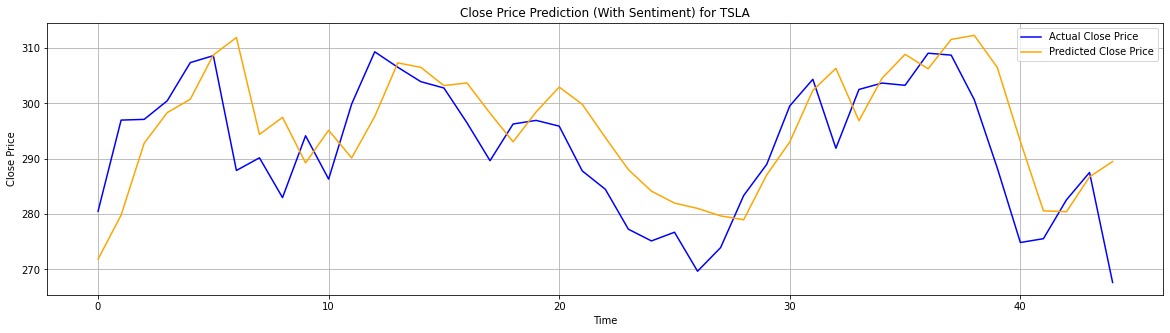

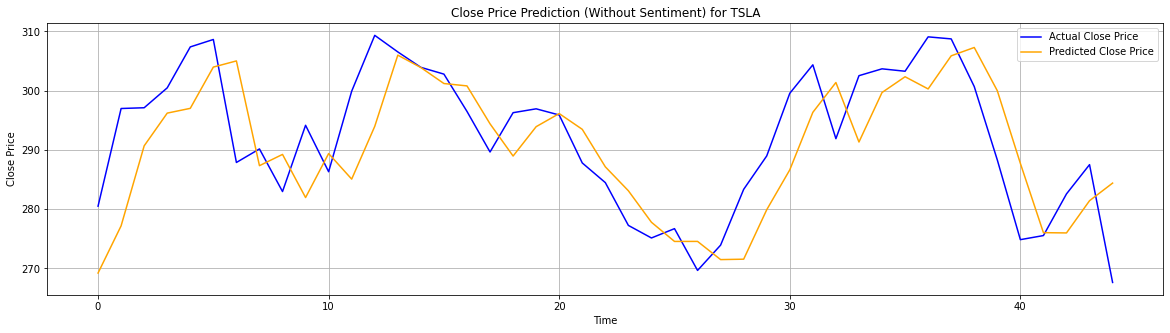

Performance of with_sentiment model for TSLA:
Mean Absolute Error (MAE): 7.49
Mean Squared Error (MSE): 90.27
R-squared (R²): 0.33

Performance of without_sentiment model for TSLA:
Mean Absolute Error (MAE): 7.04
Mean Squared Error (MSE): 74.76
R-squared (R²): 0.44

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             289.506335
1 2022-09-30  Without Sentiment             284.404826


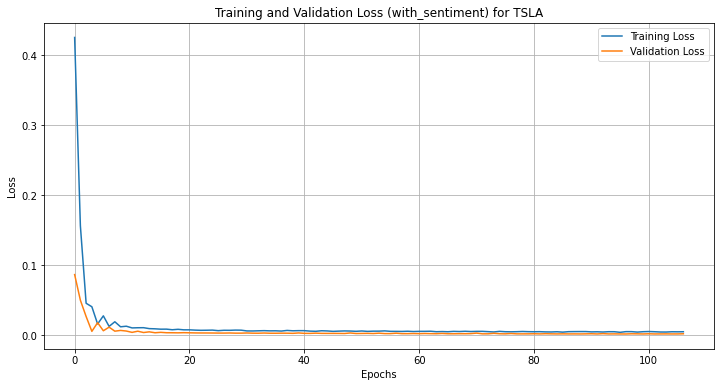

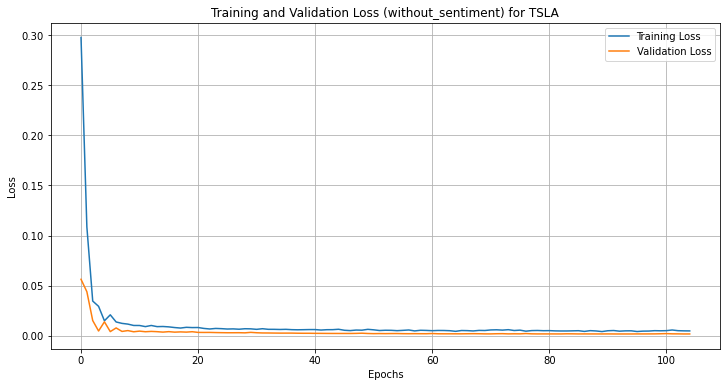

2/2 [==============================] - 1s 30ms/step


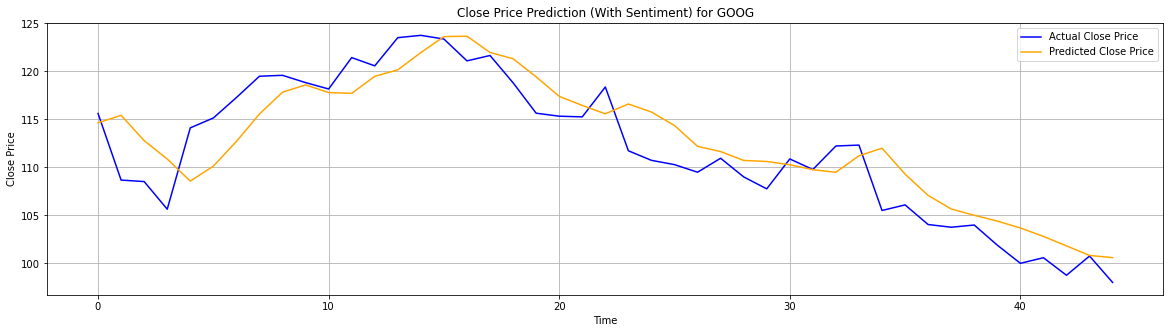

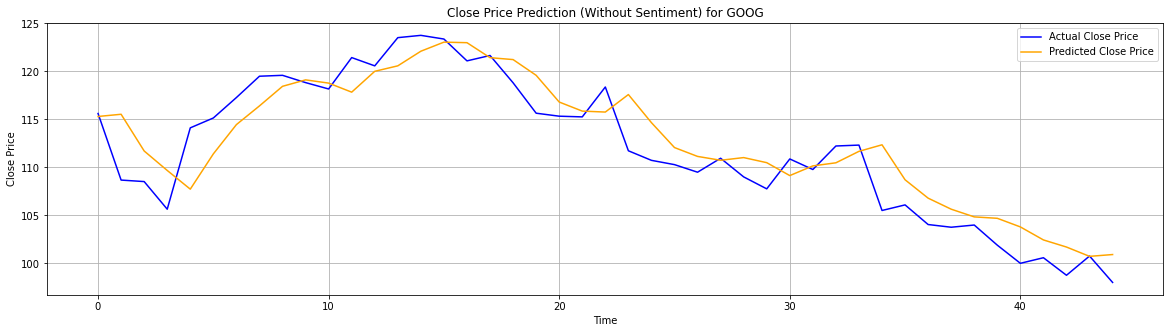

Performance of with_sentiment model for GOOG:
Mean Absolute Error (MAE): 2.67
Mean Squared Error (MSE): 10.19
R-squared (R²): 0.81

Performance of without_sentiment model for GOOG:
Mean Absolute Error (MAE): 2.37
Mean Squared Error (MSE): 8.64
R-squared (R²): 0.84

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             100.603409
1 2022-09-30  Without Sentiment             100.926123


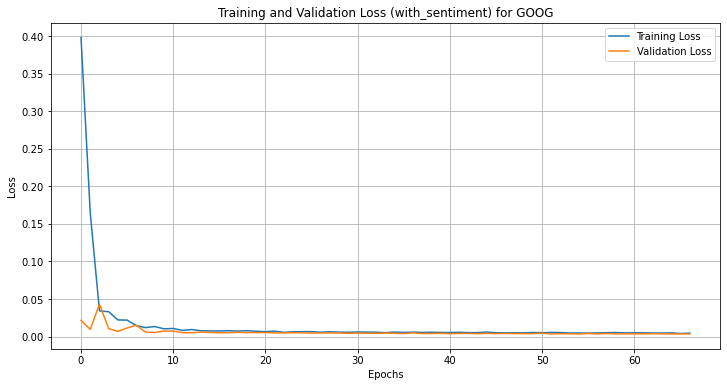

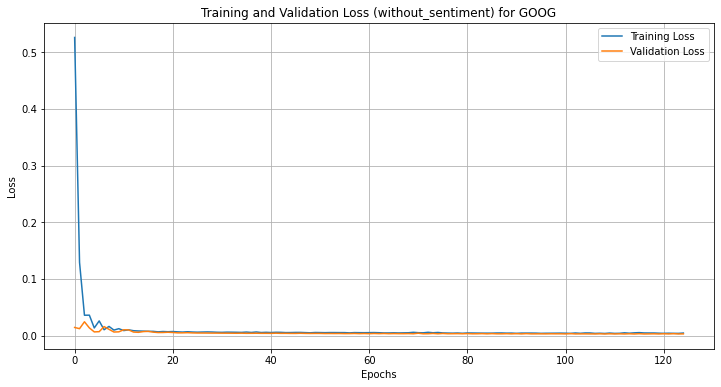

2/2 [==============================] - 1s 28ms/step


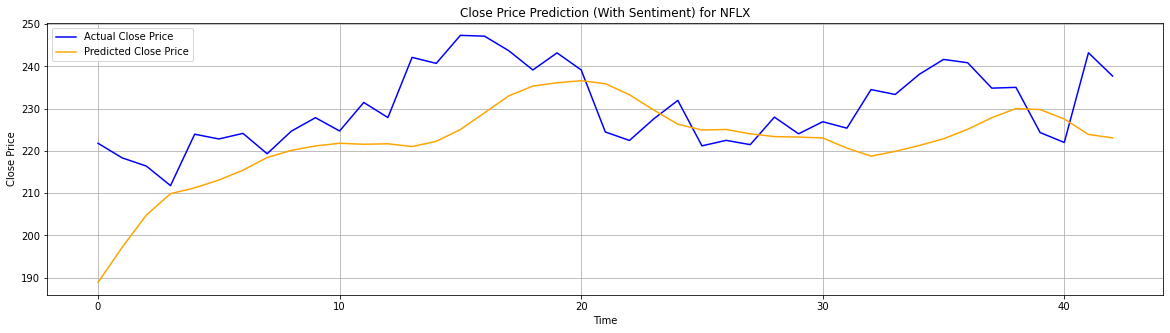

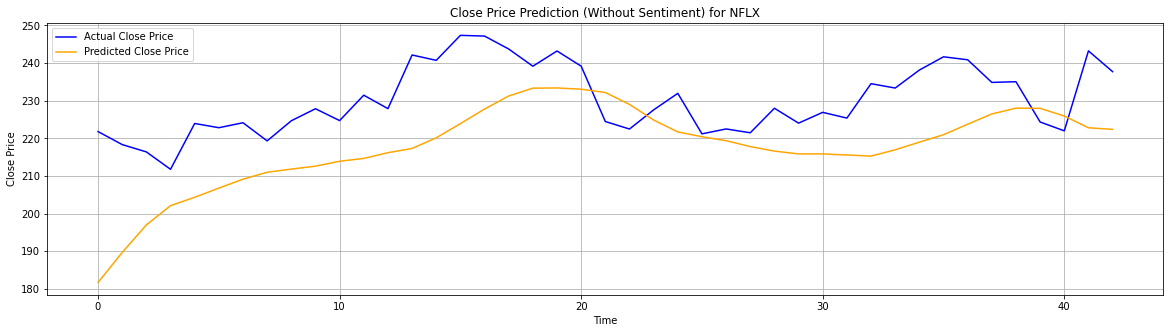

Performance of with_sentiment model for NFLX:
Mean Absolute Error (MAE): 9.88
Mean Squared Error (MSE): 149.45
R-squared (R²): -0.83

Performance of without_sentiment model for NFLX:
Mean Absolute Error (MAE): 13.33
Mean Squared Error (MSE): 238.25
R-squared (R²): -1.91

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             223.097648
1 2022-09-30  Without Sentiment             222.388435


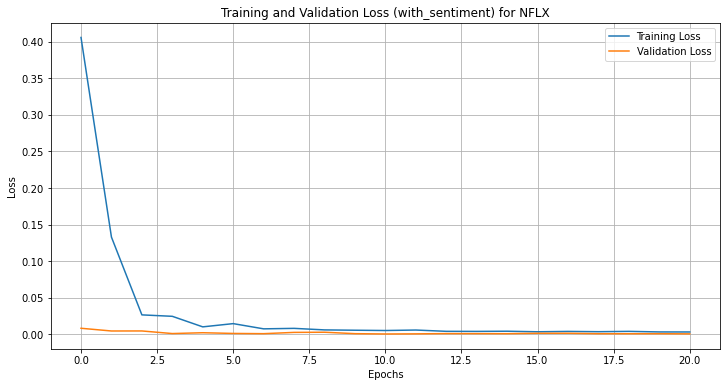

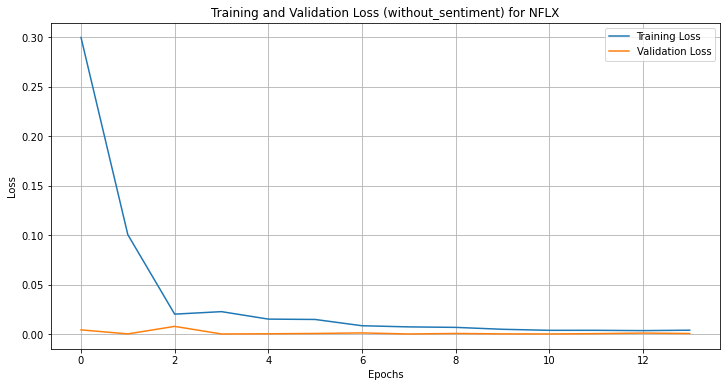

2/2 [==============================] - 1s 33ms/step


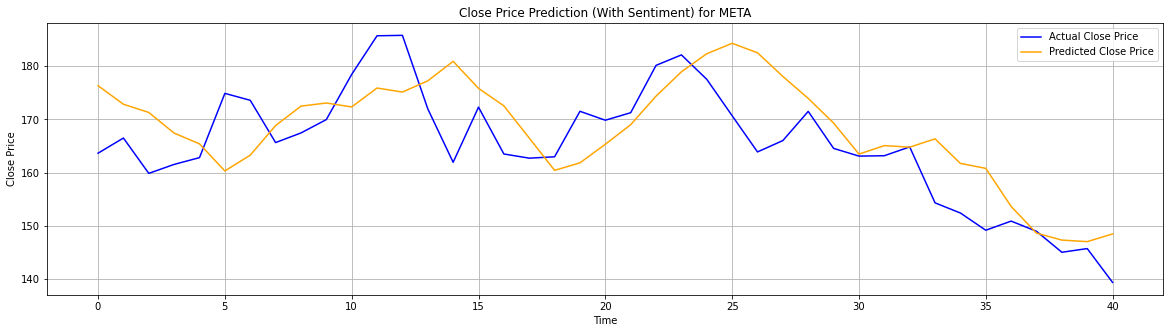

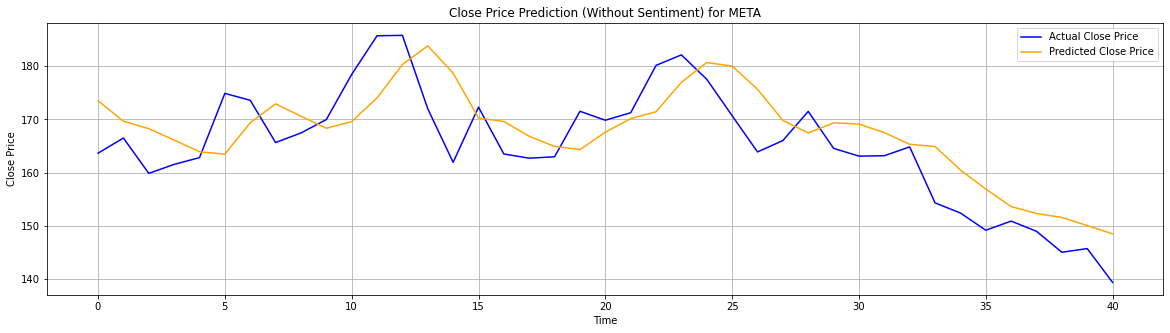

Performance of with_sentiment model for META:
Mean Absolute Error (MAE): 6.77
Mean Squared Error (MSE): 69.47
R-squared (R²): 0.39

Performance of without_sentiment model for META:
Mean Absolute Error (MAE): 6.05
Mean Squared Error (MSE): 49.94
R-squared (R²): 0.56

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             148.480426
1 2022-09-30  Without Sentiment             148.487186


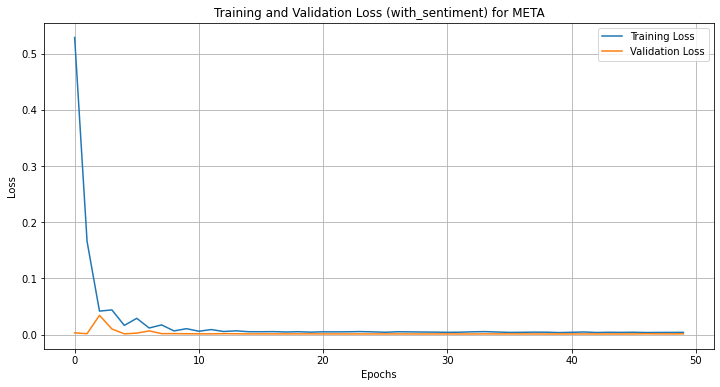

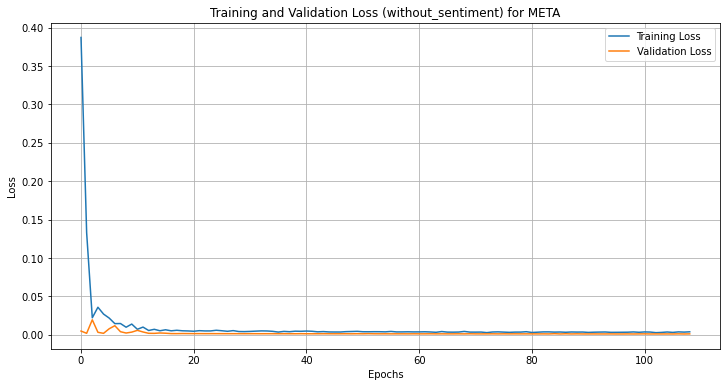

2/2 [==============================] - 1s 45ms/step


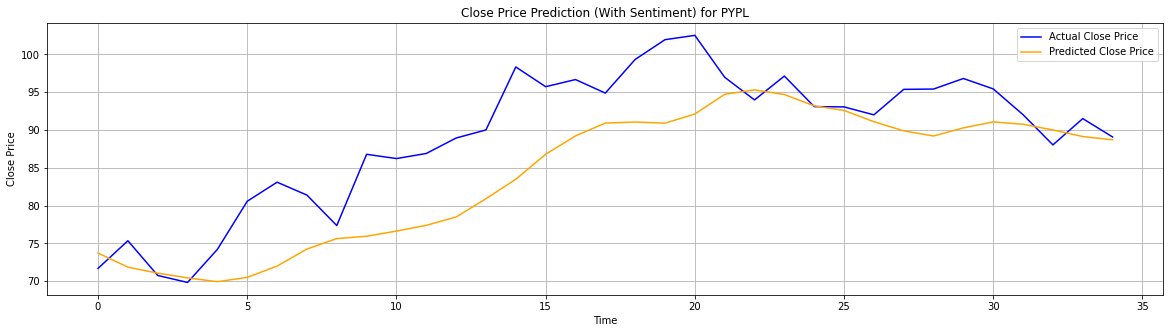

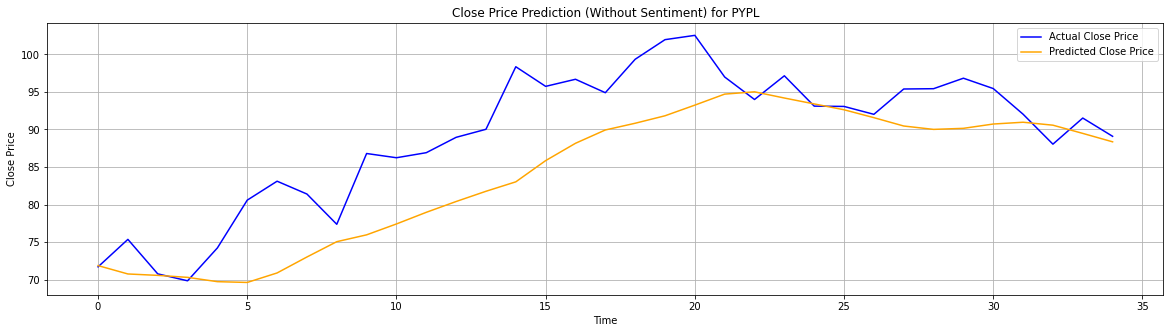

Performance of with_sentiment model for PYPL:
Mean Absolute Error (MAE): 5.47
Mean Squared Error (MSE): 46.64
R-squared (R²): 0.42

Performance of without_sentiment model for PYPL:
Mean Absolute Error (MAE): 5.44
Mean Squared Error (MSE): 46.48
R-squared (R²): 0.42

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              88.712967
1 2022-09-30  Without Sentiment              88.351455


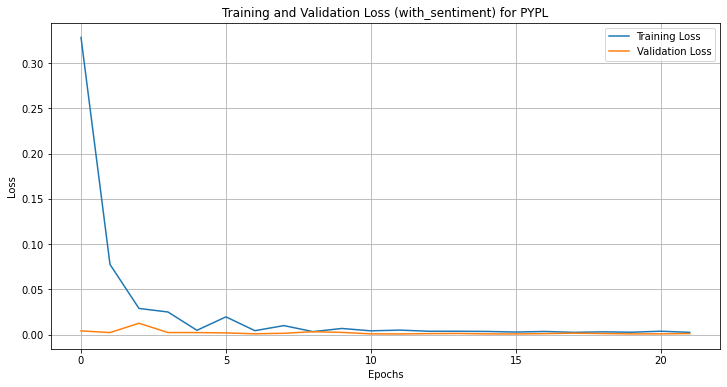

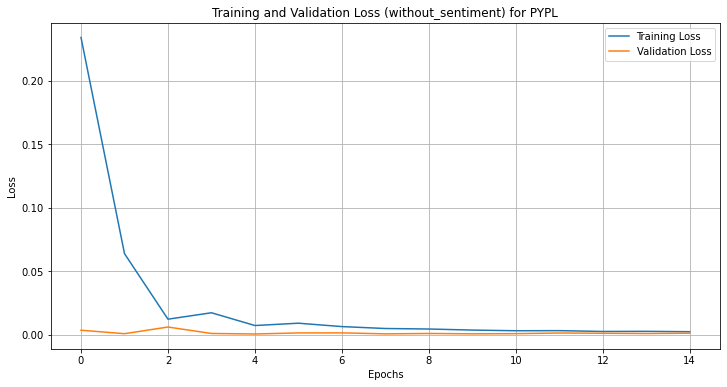

2/2 [==============================] - 1s 50ms/step


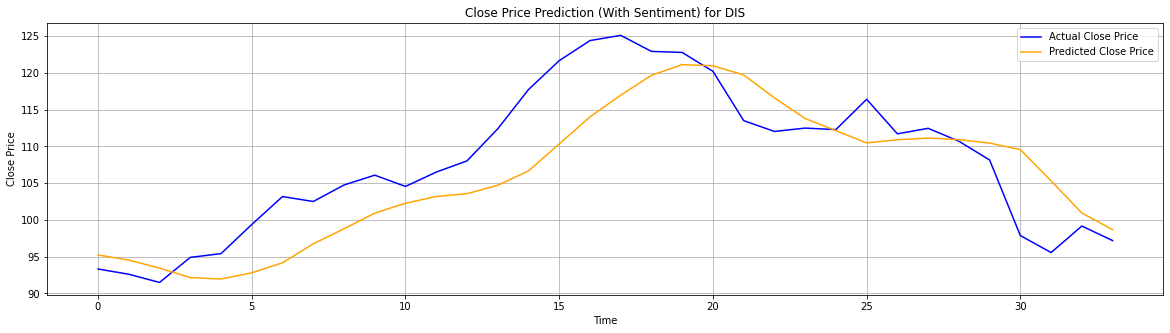

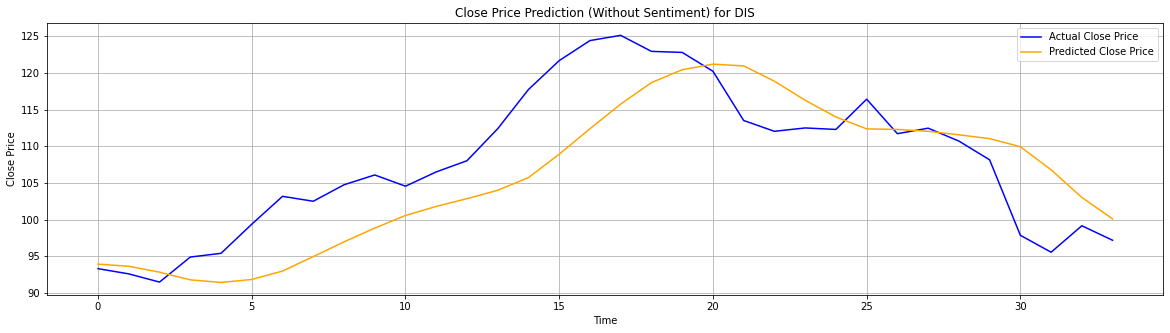

Performance of with_sentiment model for DIS:
Mean Absolute Error (MAE): 4.60
Mean Squared Error (MSE): 33.15
R-squared (R²): 0.66

Performance of without_sentiment model for DIS:
Mean Absolute Error (MAE): 5.44
Mean Squared Error (MSE): 44.09
R-squared (R²): 0.55

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment              98.659977
1 2022-09-30  Without Sentiment             100.091589


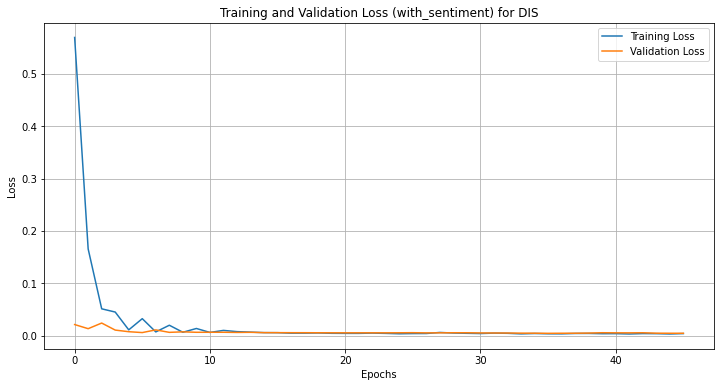

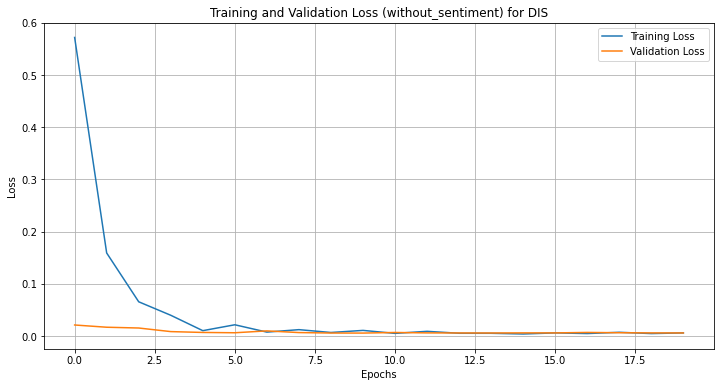

1/1 [==============================] - 1s 898ms/step


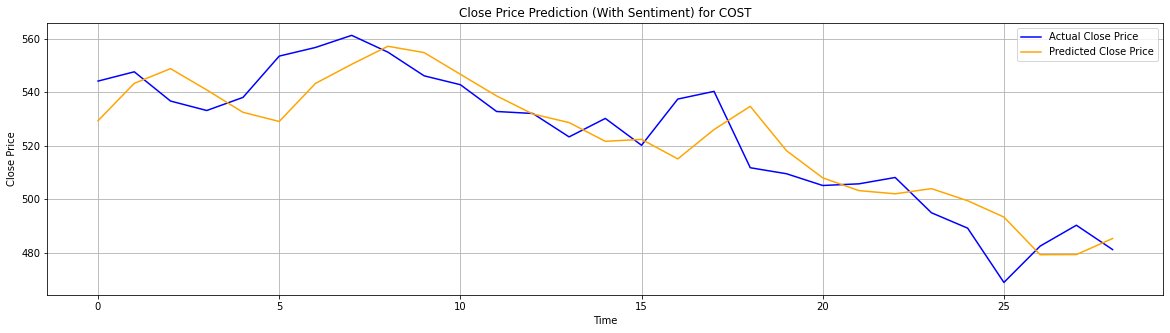

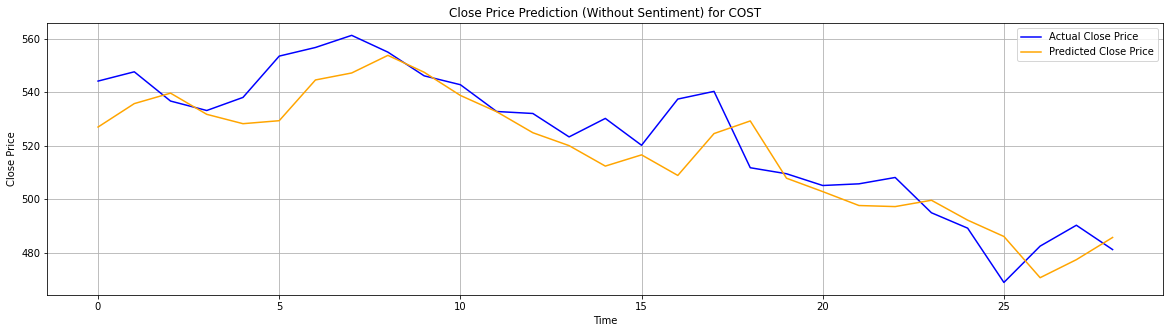

Performance of with_sentiment model for COST:
Mean Absolute Error (MAE): 9.38
Mean Squared Error (MSE): 134.44
R-squared (R²): 0.79

Performance of without_sentiment model for COST:
Mean Absolute Error (MAE): 9.35
Mean Squared Error (MSE): 141.46
R-squared (R²): 0.78

        Date              Model  Predicted Close Price
0 2022-09-30     With Sentiment             485.272808
1 2022-09-30  Without Sentiment             485.661825


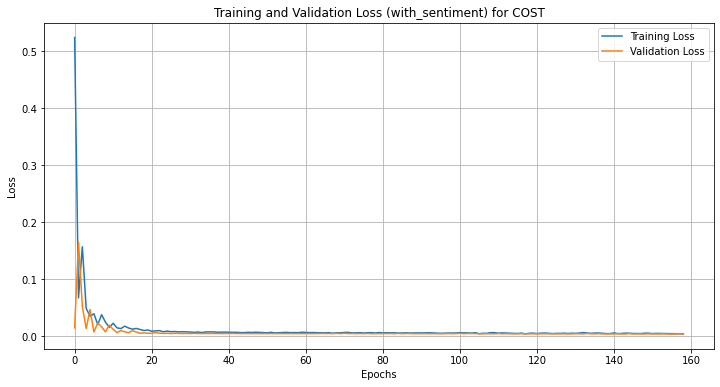

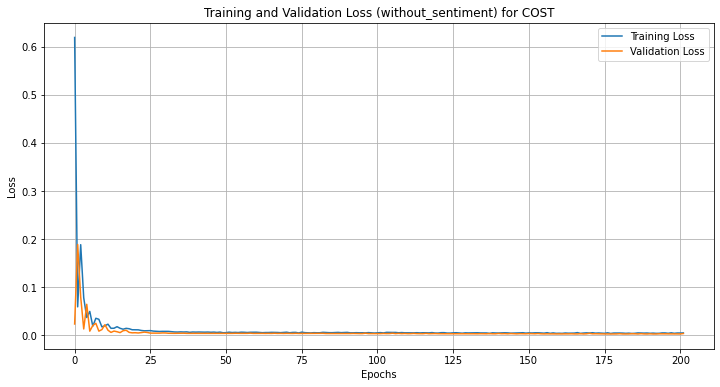

1/1 [==============================] - 1s 790ms/step


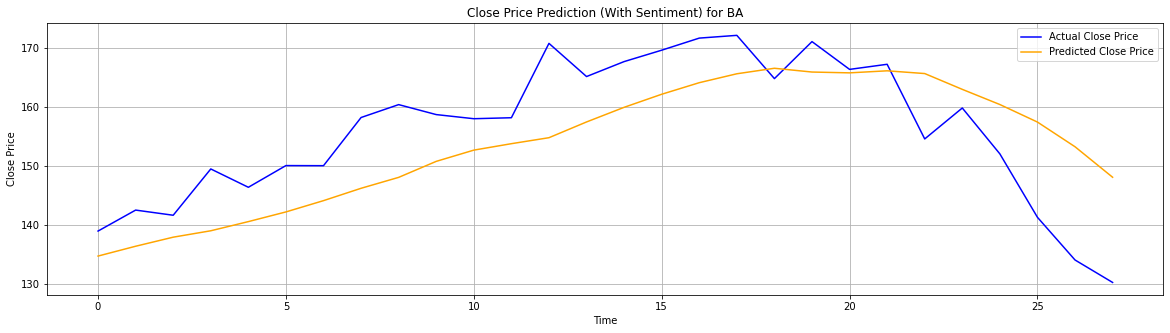

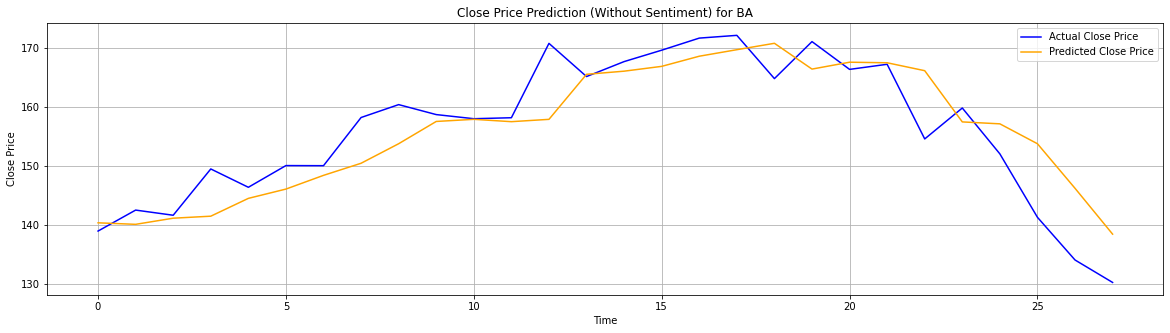

Performance of with_sentiment model for BA:
Mean Absolute Error (MAE): 7.98
Mean Squared Error (MSE): 86.60
R-squared (R²): 0.39

Performance of without_sentiment model for BA:
Mean Absolute Error (MAE): 4.40
Mean Squared Error (MSE): 35.18
R-squared (R²): 0.75

        Date              Model  Predicted Close Price
0 2022-09-27     With Sentiment             148.131853
1 2022-09-27  Without Sentiment             138.494699


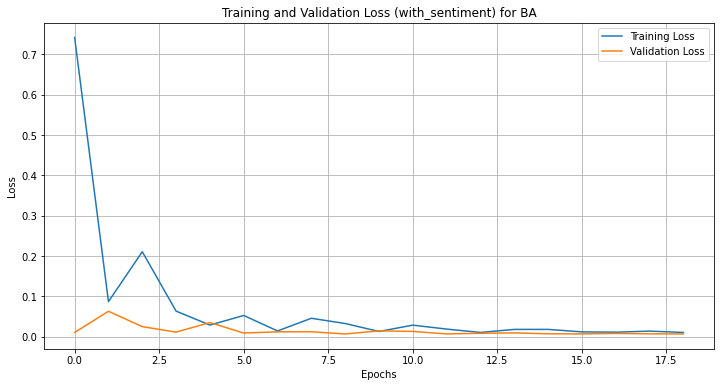

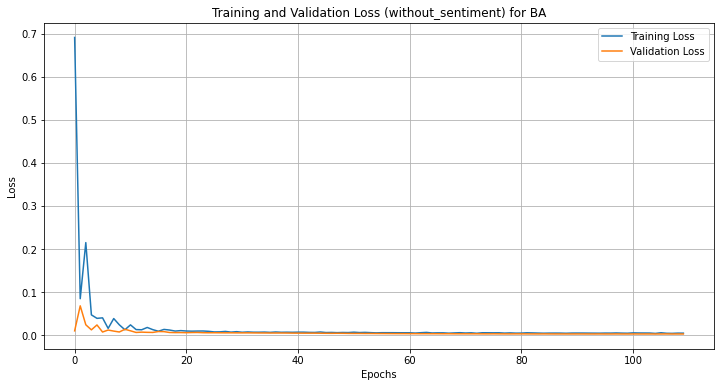

In [171]:
#Count the number of occurrences of each stock in the merged_data
stock_counts = merged_data['Stock Name'].value_counts()

# Filter stocks that have more than 100 entries
filtered_stocks = stock_counts[stock_counts > 150].index

# Loop through the filtered stocks and call the predict_stock_price_gru function
for stock in filtered_stocks:
    predict_stock_price_gru(merged_data, stock)

In [177]:
Close_predection = {
    'Stock Name': ['PG', 'AMZN', 'AAPL', 'TSM', 'NIO', 'MSFT', 'AMD', 'TSLA', 
                   'GOOG', 'NFLX', 'META', 'PYPL', 'DIS', 'COST', 'BA'],
    'Date': ['2022-09-30'] * 15,  
    'Predicted Close (Without Sentiment)': [
        138.272365, 118.368747, 151.540161, 77.704206, 17.483944, 
        240.714382, 71.622991, 284.404826, 100.926123, 222.388435,
        148.487186, 88.351455, 100.091589, 485.661825, 138.494699
    ],
    'Predicted Close (With Sentiment)': [
        135.703589, 118.880869, 149.768399, 74.482055, 17.560625,
        242.525458, 71.177120, 289.506335, 100.603409, 223.097648,
        148.480426, 88.712967, 98.659977, 485.272808, 148.131853
    ],
    'R² (With Sentiment)': [
        0.76, 0.84, 0.82, 0.85, 0.63, 0.90, 0.89, 0.33, 0.81, 
        -0.83, 0.39, 0.42, 0.66, 0.79, 0.39
    ],
    'R² (Without Sentiment)': [
        0.58, 0.83, 0.79, 0.52, 0.60, 0.88, 0.90, 0.44, 0.84,
        -1.91, 0.56, 0.42, 0.55, 0.78, 0.75
    ]
}

# Create DataFrame
Close_predection = pd.DataFrame(Close_predection)

# Display the DataFrame
print(Close_predection)

Close_predection.to_csv("Close_predection.csv", index=False)


   Stock Name        Date  Predicted Close (Without Sentiment)  \
0          PG  2022-09-30                           138.272365   
1        AMZN  2022-09-30                           118.368747   
2        AAPL  2022-09-30                           151.540161   
3         TSM  2022-09-30                            77.704206   
4         NIO  2022-09-30                            17.483944   
5        MSFT  2022-09-30                           240.714382   
6         AMD  2022-09-30                            71.622991   
7        TSLA  2022-09-30                           284.404826   
8        GOOG  2022-09-30                           100.926123   
9        NFLX  2022-09-30                           222.388435   
10       META  2022-09-30                           148.487186   
11       PYPL  2022-09-30                            88.351455   
12        DIS  2022-09-30                           100.091589   
13       COST  2022-09-30                           485.661825   
14        